## Description:
Splits isocontours into low- and high-curvature groups for model verification.


In [1]:
from __future__ import annotations
from pathlib import Path
import os
os.chdir("../../..")
import yaml
import numpy as np
import pandas as pd
from sklearn.linear_model import HuberRegressor, LinearRegression
from flamekit.io_fronts import Case, load_fronts


### Read config file and define helper functions


Load configuration values and plotting style settings.


In [2]:
PROJECT_ROOT = Path.cwd().resolve()
CONFIG_PATH = PROJECT_ROOT / "notebooks" / "case_studies/Model_verification" / "Model_verification.yaml"
CFG = yaml.safe_load(CONFIG_PATH.read_text(encoding="utf-8"))

DATA_BASE_DIR = PROJECT_ROOT / Path(CFG["BASE_DIR"])
PHI = float(CFG["PHI"])
LAT_SIZE = str(CFG["LAT_SIZE"])
TIME_STEPS = list(CFG["TIME_STEPS"])

PROGRESS_LEVELS = list(CFG["PROGRESS_LEVELS"])
POST = bool(CFG["POST"])
MULTIPLE_RUNS = bool(CFG["MULTIPLE_RUNS"])
N_RUN = int(CFG["N_RUN"])

CURVATURE_COLUMN = str(CFG["CURVATURE_COLUMN"])
CURVATURE_LOW = float(CFG["CURVATURE_LOW"])
CURVATURE_HIGH = float(CFG["CURVATURE_HIGH"])

T_REF = float(CFG.get("T_REF", 300.0))
TEMPERATURE_NONDIM = bool(CFG.get("TEMPERATURE_NONDIM", True))
C_CONSTANT = float(CFG.get("C_CONSTANT", 0.0))
REMOVE_OUTLIERS = bool(CFG.get("REMOVE_OUTLIERS", True))
OUTLIER_IQR_SCALE = float(CFG.get("OUTLIER_IQR_SCALE", 1.5))



SAVE_SPLITS = bool(CFG["SAVE_SPLITS"])
REPORT_BASE_DIR = PROJECT_ROOT / Path(CFG["OUT_BASE_DIR"])

PHI_TAG = f"phi_{PHI:g}"
LAT_TAG = f"h400x{LAT_SIZE}_ref"


def time_dir(time_step: int) -> Path:
    return REPORT_BASE_DIR / PHI_TAG / LAT_TAG / f"t_{time_step}"


def case_out_dir(time_step: int, c_val: float | None = None, *parts: str) -> Path:
    out = time_dir(time_step)
    if c_val is not None and len(PROGRESS_LEVELS) > 1:
        out = out / f"T_{float(c_val):g}"
    for part in parts:
        out = out / part
    return out
LOW_FNAME_FMT = "curvature_le_{low:g}.csv"
HIGH_FNAME_FMT = "curvature_ge_{high:g}.csv"

if CURVATURE_LOW >= CURVATURE_HIGH:
    raise ValueError("CURVATURE_LOW must be < CURVATURE_HIGH")

# ============================================================
# PLOT STYLE (template-based)
# ============================================================
import matplotlib.pyplot as plt

PLOT_FONT_FAMILY = str(CFG.get("PLOT_FONT_FAMILY", "Courier New"))
PLOT_FONT_SIZE = int(CFG.get("PLOT_FONT_SIZE", 20))
FIG_DPI = int(CFG.get("FIG_DPI", 250))
FIG_SIZE_RAW = CFG.get("FIG_SIZE", (6.8, 6.2))
if isinstance(FIG_SIZE_RAW, (list, tuple)) and len(FIG_SIZE_RAW) == 2:
    FIG_SIZE = (float(FIG_SIZE_RAW[0]), float(FIG_SIZE_RAW[1]))
else:
    FIG_SIZE = (6.8, 6.2)

PLOT_USE_TEX = bool(CFG.get("PLOT_USE_TEX", False))
PLOT_TEX_PREAMBLE_RAW = CFG.get("PLOT_TEX_PREAMBLE", "")
if isinstance(PLOT_TEX_PREAMBLE_RAW, (list, tuple)):
    PLOT_TEX_PREAMBLE = "\n".join(str(item) for item in PLOT_TEX_PREAMBLE_RAW if item)
else:
    PLOT_TEX_PREAMBLE = str(PLOT_TEX_PREAMBLE_RAW) if PLOT_TEX_PREAMBLE_RAW is not None else ""

def apply_plot_style() -> None:
    params = {
        "font.family": PLOT_FONT_FAMILY,
        "font.size": PLOT_FONT_SIZE,
        "axes.titlesize": PLOT_FONT_SIZE,
        "axes.labelsize": PLOT_FONT_SIZE,
        "xtick.labelsize": PLOT_FONT_SIZE,
        "ytick.labelsize": PLOT_FONT_SIZE,
        "legend.fontsize": PLOT_FONT_SIZE,
        "figure.titlesize": PLOT_FONT_SIZE,
        "axes.linewidth": 1.2,
        "text.usetex": PLOT_USE_TEX,
    }
    if PLOT_TEX_PREAMBLE:
        params["text.latex.preamble"] = PLOT_TEX_PREAMBLE
    plt.rcParams.update(params)

apply_plot_style()

COLOR_DATA = str(CFG.get("COLOR_DATA", "#77b5b6"))
COLOR_DATA_EDGE = str(CFG.get("COLOR_DATA_EDGE", "#378d94"))
COLOR_PRED = str(CFG.get("COLOR_PRED", "#9671bd"))
COLOR_PRED_EDGE = str(CFG.get("COLOR_PRED_EDGE", "#6a408d"))
COLOR_NEUTRAL = str(CFG.get("COLOR_NEUTRAL", "#7e7e7e"))
COLOR_LINE = str(CFG.get("COLOR_LINE", "#8a8a8a"))

LABEL_CURV = r"$\kappa^*$"
LABEL_STRETCH = r"$\mathbb{K}^*$"
LABEL_SD = r"$\tilde{S}_d^*$"




def style_axes(ax, *, equal: bool = False) -> None:
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle="-", linewidth=0.75, alpha=0.25)
    ax.grid(True, which="minor", linestyle="-", linewidth=0.25, alpha=0.15)
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)
    ax.tick_params(axis="both", which="major", length=6, width=1.0)
    ax.tick_params(axis="both", which="minor", length=3, width=0.8)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    if equal:
        ax.set_aspect("equal", adjustable="box")

def save_multi_fig(fig, base: Path, suffix: str) -> None:
    out = base.with_name(f"{base.name}_{suffix}")
    fig.savefig(out.with_suffix(".png"), dpi=FIG_DPI)
    fig.savefig(out.with_suffix(".pdf"))
    fig.savefig(out.with_suffix(".svg"))

# ============================================================
# HELPERS
# ============================================================
def make_case(time_step: int) -> Case:
    base_kwargs = dict(
        base_dir=DATA_BASE_DIR,
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=time_step,
        post=POST,
    )
    try:
        return Case(
            **base_kwargs,
            multiple_runs=MULTIPLE_RUNS,
            n_run=N_RUN
        )
    except TypeError:
        return Case(**base_kwargs)

def make_out_dir(time_step: int, c_val: float) -> Path:
    return case_out_dir(time_step, c_val)

def require_columns(df: pd.DataFrame, cols: list[str], context: str = "") -> None:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"{context} Missing columns: {missing}")

def clean_valid_rows(df: pd.DataFrame, cols_needed: list[str]) -> pd.DataFrame:
    valid = df[cols_needed].replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")
    return df.loc[valid.index].copy()

def remove_outliers_iqr(
    df: pd.DataFrame,
    cols: list[str],
    iqr_scale: float = 1.5,
) -> pd.DataFrame:
    if df.empty:
        return df.copy()
    mask = pd.Series(True, index=df.index)
    for col in cols:
        q1 = float(df[col].quantile(0.25))
        q3 = float(df[col].quantile(0.75))
        iqr = q3 - q1
        if not np.isfinite(iqr) or iqr == 0.0:
            continue
        lower = q1 - iqr_scale * iqr
        upper = q3 + iqr_scale * iqr
        mask &= df[col].between(lower, upper)
    return df.loc[mask].copy()

def apply_outlier_filter(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    if not REMOVE_OUTLIERS:
        return df.copy()
    return remove_outliers_iqr(df, cols, iqr_scale=OUTLIER_IQR_SCALE)

def split_by_curvature(df: pd.DataFrame, col: str, low: float, high: float) -> tuple[pd.DataFrame, pd.DataFrame]:
    low_df = df[df[col] <= low].copy()
    high_df = df[df[col] >= high].copy()
    return low_df, high_df

def save_split(df: pd.DataFrame, savepath: Path | None, label: str) -> None:
    if savepath is None:
        return
    if df.empty:
        print(f"  {label}: skipped save (n=0)")
        return
    df.to_csv(savepath, index=False)



### Run


Split isocontours by curvature and save subsets.


In [3]:
for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        require_columns(front, [CURVATURE_COLUMN], context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, [CURVATURE_COLUMN])

        low_df, high_df = split_by_curvature(dfv, CURVATURE_COLUMN, CURVATURE_LOW, CURVATURE_HIGH)
        print(
            f"t={t}, T={float(c_val):.2f}: n_total={len(dfv)}, n_low={len(low_df)}, n_high={len(high_df)}"
        )

        if SAVE_SPLITS:
            out_dir = make_out_dir(t, float(c_val))
            out_dir.mkdir(parents=True, exist_ok=True)
            low_path = out_dir / LOW_FNAME_FMT.format(low=CURVATURE_LOW)
            high_path = out_dir / HIGH_FNAME_FMT.format(high=CURVATURE_HIGH)
            save_split(low_df, low_path, "low")
            save_split(high_df, high_path, "high")


t=200, T=0.60: n_total=6491, n_low=1120, n_high=3011


Isocontour scatter plots before regression.


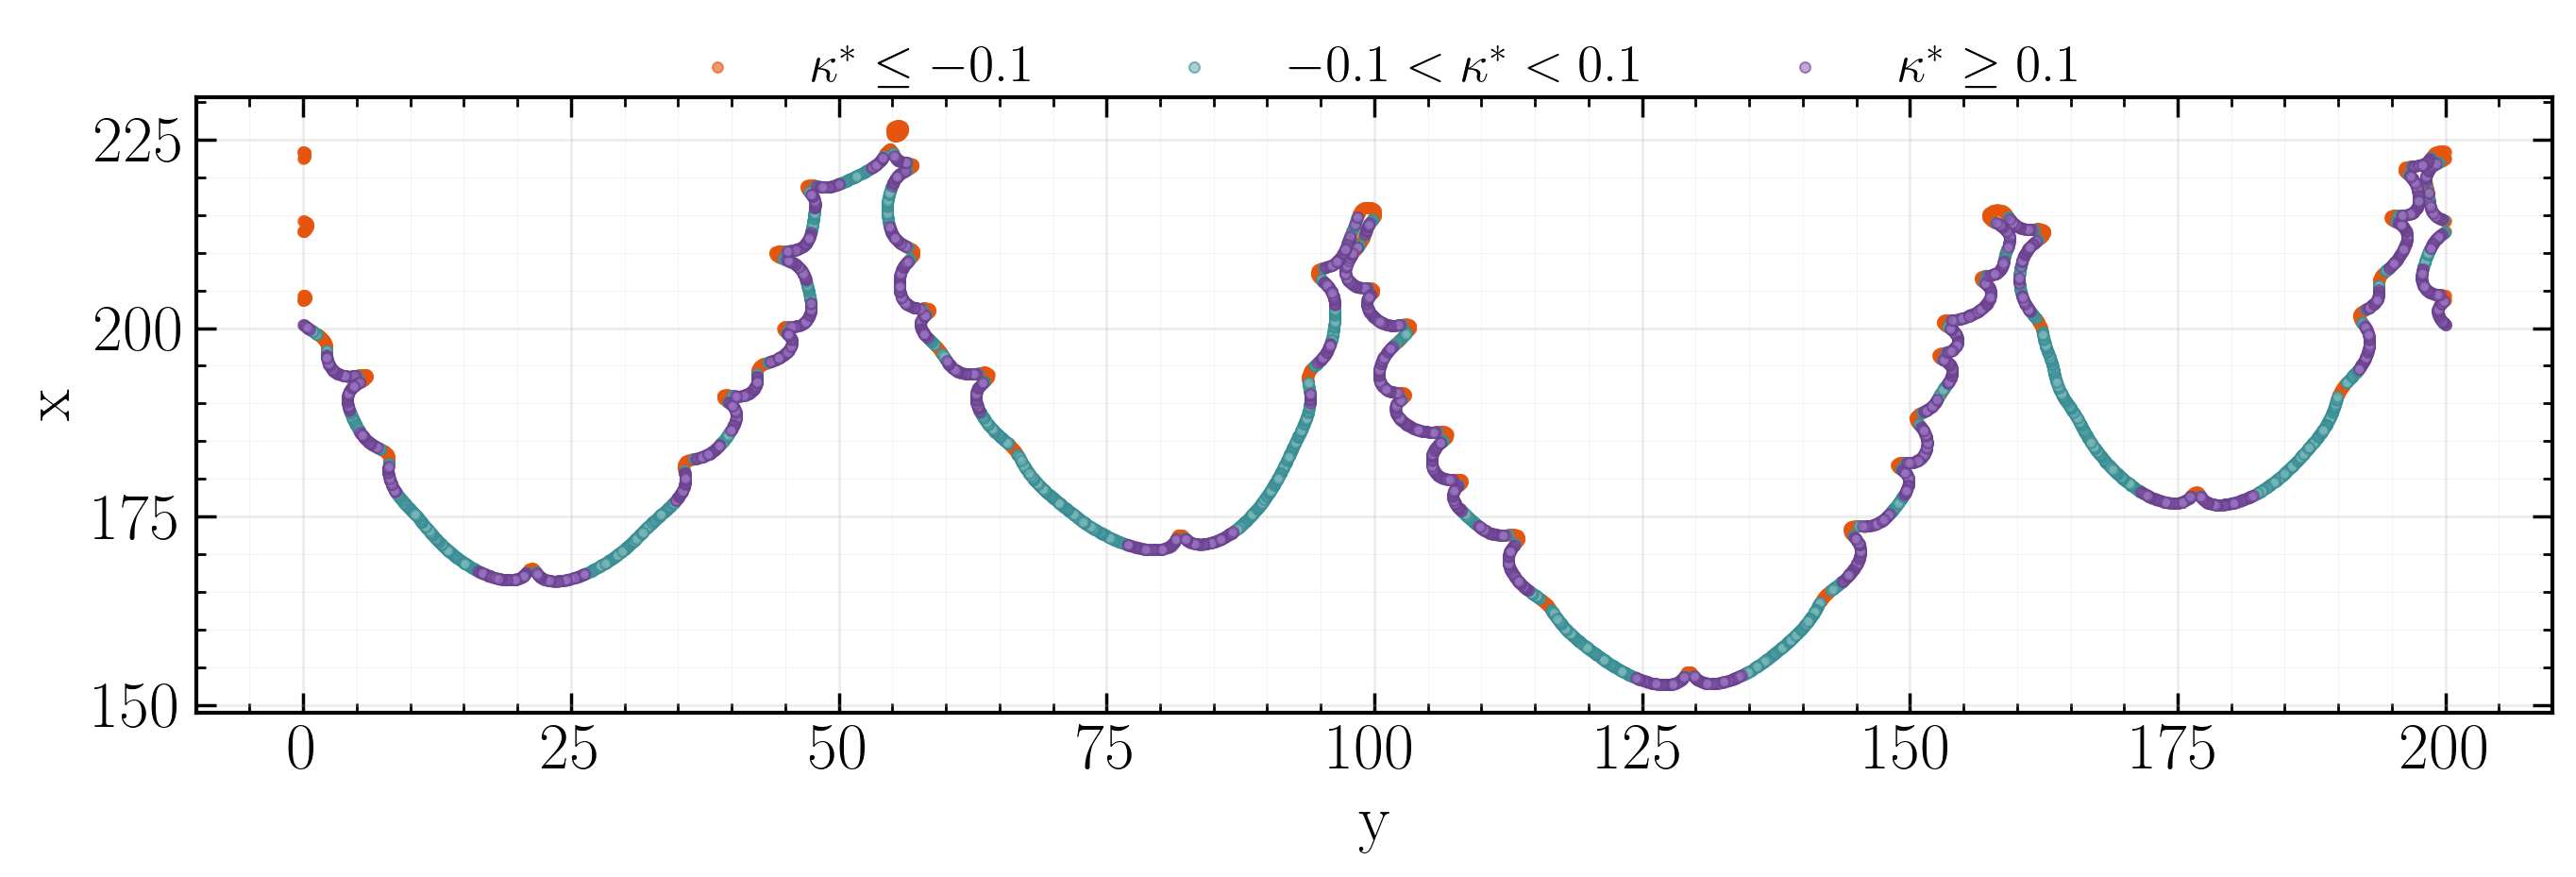

In [4]:
# Isocontour scatter plot (x vs y) before regressions
import matplotlib.pyplot as plt

SCATTER_S_ISO = 10
ALPHA_ISO = 0.6
SAVE_ISO_SCATTER = True
ISO_SCATTER_DIR = "isocontour_scatter"
ISO_FIG_SIZE = (10.8, 3.6)
NEG_CURV_COLOR = "#e6550d"
LEGEND_ISO_KWARGS = dict(
    frameon=False,
    fontsize=PLOT_FONT_SIZE - 4,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.12),
    ncol=3,
    borderaxespad=0.0,
)
CURV_LABEL_RAW = LABEL_CURV.strip("$")

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()
        require_columns(front, ["x", "y", CURVATURE_COLUMN], context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, ["x", "y", CURVATURE_COLUMN])

        neg_df = dfv[dfv[CURVATURE_COLUMN] <= CURVATURE_LOW]
        pos_df = dfv[dfv[CURVATURE_COLUMN] >= CURVATURE_HIGH]
        mid_df = dfv[(dfv[CURVATURE_COLUMN] > CURVATURE_LOW) & (dfv[CURVATURE_COLUMN] < CURVATURE_HIGH)]

        fig, ax = plt.subplots(figsize=ISO_FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
        ax.scatter(
            neg_df["y"],
            neg_df["x"],
            s=SCATTER_S_ISO,
            alpha=ALPHA_ISO,
            color=NEG_CURV_COLOR,
            edgecolors=NEG_CURV_COLOR,
            linewidths=0.6,
            zorder=2,
            label=rf"${CURV_LABEL_RAW} \le {CURVATURE_LOW:g}$",
        )
        ax.scatter(
            mid_df["y"],
            mid_df["x"],
            s=SCATTER_S_ISO,
            alpha=ALPHA_ISO,
            color=COLOR_DATA,
            edgecolors=COLOR_DATA_EDGE,
            linewidths=0.6,
            zorder=3,
            label=rf"${CURVATURE_LOW:g} < {CURV_LABEL_RAW} < {CURVATURE_HIGH:g}$",
        )
        ax.scatter(
            pos_df["y"],
            pos_df["x"],
            s=SCATTER_S_ISO,
            alpha=ALPHA_ISO,
            color=COLOR_PRED,
            edgecolors=COLOR_PRED_EDGE,
            linewidths=0.6,
            zorder=4,
            label=rf"${CURV_LABEL_RAW} \ge {CURVATURE_HIGH:g}$",
        )
        ax.set_xlabel("y")
        ax.set_ylabel("x")
        ax.legend(**LEGEND_ISO_KWARGS)
        style_axes(ax)

        savepath = None
        if SAVE_ISO_SCATTER:
            out_dir = case_out_dir(t, c_val, ISO_SCATTER_DIR)
            out_dir.mkdir(parents=True, exist_ok=True)
            savepath = out_dir / "isocontour_scatter"
            fig.savefig(savepath.with_suffix(".png"), dpi=FIG_DPI, bbox_inches="tight")
            fig.savefig(savepath.with_suffix(".pdf"), bbox_inches="tight")
            fig.savefig(savepath.with_suffix(".svg"), bbox_inches="tight")

        plt.show()
        plt.close(fig)





All-data scatter: Sd vs curvature.


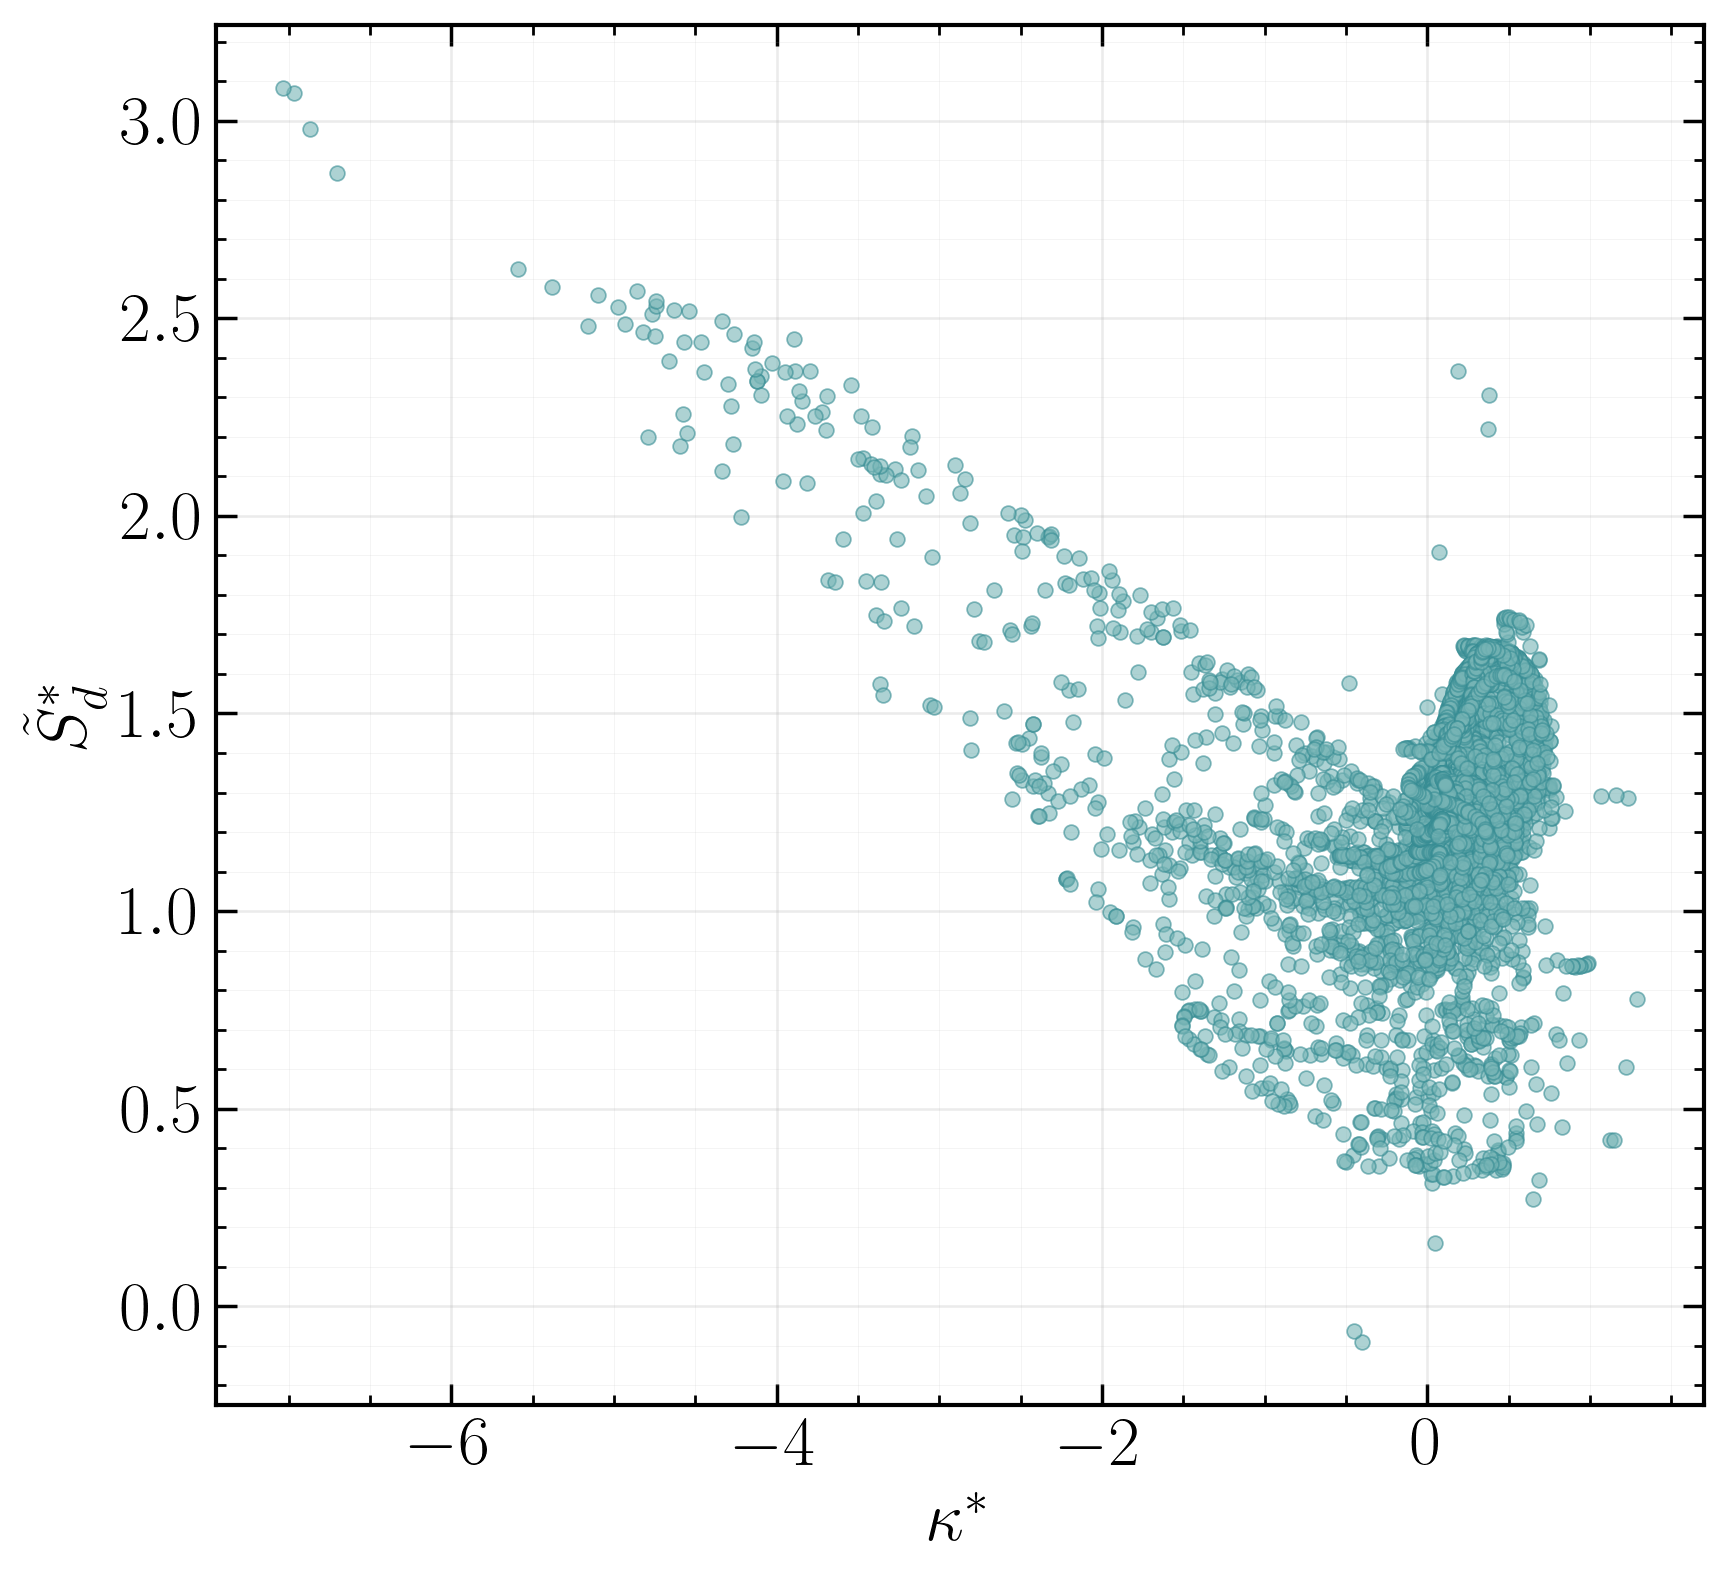

In [5]:
# Sd vs curvature using all data
import matplotlib.pyplot as plt

TARGET_COLUMN = "DW_FDS"
STRETCH_COLUMN = "stretch_rate"

SAVE_ALL_DATA_PLOTS = True
ALL_DATA_OUT_DIR = "all_data_plots"
ALL_SCATTER_S = 18
ALL_ALPHA = 0.6

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        savepath = None
        if SAVE_ALL_DATA_PLOTS:
            out_dir = case_out_dir(t, c_val, ALL_DATA_OUT_DIR)
            out_dir.mkdir(parents=True, exist_ok=True)
            savepath = out_dir / "all_data"

        fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
        ax.scatter(
            dfv[CURVATURE_COLUMN],
            dfv[TARGET_COLUMN],
            s=ALL_SCATTER_S,
            alpha=ALL_ALPHA,
            color=COLOR_DATA,
            edgecolors=COLOR_DATA_EDGE,
            linewidths=0.5,
            zorder=3,
        )
        ax.set_xlabel(LABEL_CURV)
        ax.set_ylabel(LABEL_SD)
        style_axes(ax)
        if savepath is not None:
            save_multi_fig(fig, savepath, "sd_vs_curvature")
        plt.show()
        plt.close(fig)


All-data scatter: Sd vs stretch.


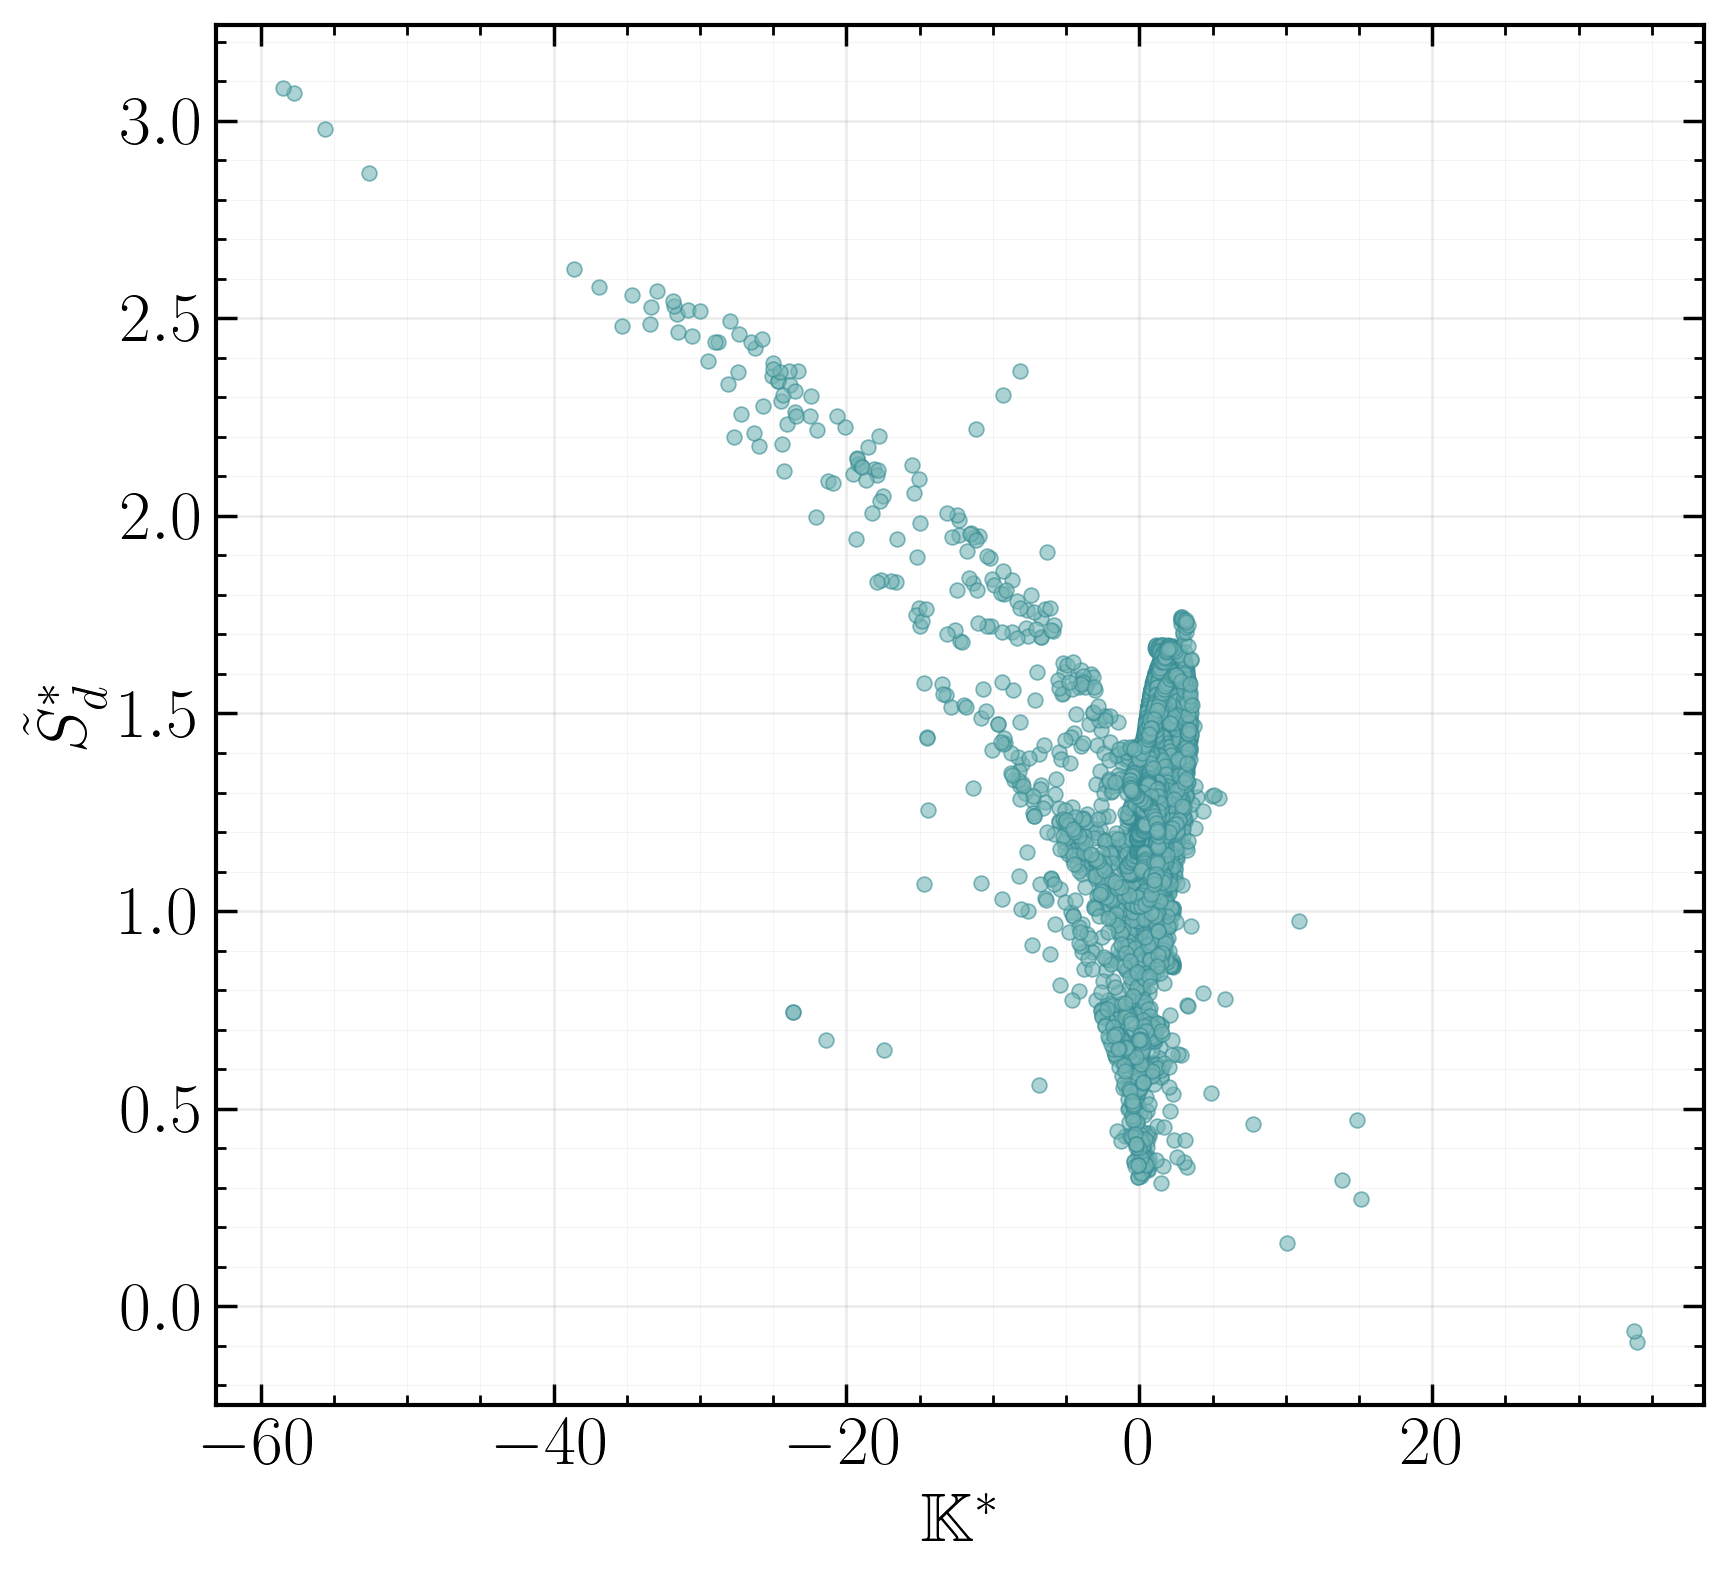

In [6]:
# Sd vs stretch using all data
import matplotlib.pyplot as plt

TARGET_COLUMN = "DW_FDS"
STRETCH_COLUMN = "stretch_rate"

SAVE_ALL_DATA_PLOTS = True
ALL_DATA_OUT_DIR = "all_data_plots"
ALL_SCATTER_S = 18
ALL_ALPHA = 0.6

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        savepath = None
        if SAVE_ALL_DATA_PLOTS:
            out_dir = case_out_dir(t, c_val, ALL_DATA_OUT_DIR)
            out_dir.mkdir(parents=True, exist_ok=True)
            savepath = out_dir / "all_data"
        
        fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
        ax.scatter(
            dfv[STRETCH_COLUMN],
            dfv[TARGET_COLUMN],
            s=ALL_SCATTER_S,
            alpha=ALL_ALPHA,
            color=COLOR_DATA,
            edgecolors=COLOR_DATA_EDGE,
            linewidths=0.5,
            zorder=3,
        )
        ax.set_xlabel(LABEL_STRETCH)
        ax.set_ylabel(LABEL_SD)
        style_axes(ax)
        if savepath is not None:
            save_multi_fig(fig, savepath, "sd_vs_stretch")
        plt.show()
        plt.close(fig)


Joint fit for positive-curvature data (curvature + stretch).


In [7]:
# Fit Sd = 1 - L_curv * curvature - L_str * stretch_rate on positive-curvature group
TARGET_COLUMN = "DW_FDS"
STRETCH_COLUMN = "stretch_rate"

def fit_markstein_lengths(
    df: pd.DataFrame,
    curv_col: str,
    stretch_col: str,
    target_col: str,
) -> tuple[float, float, float, float]:
    X = df[[curv_col, stretch_col]].to_numpy()
    y_true = df[target_col].to_numpy()
    y_fit = 1.0 - y_true
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y_fit)
    y_pred = 1.0 - model.predict(X)
    ss_res = float(((y_true - y_pred) ** 2).sum())
    ss_tot = float(((y_true - y_true.mean()) ** 2).sum())
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else float("nan")
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    return float(model.coef_[0]), float(model.coef_[1]), r2, rmse

def fit_markstein_lengths_huber(
    df: pd.DataFrame,
    curv_col: str,
    stretch_col: str,
    target_col: str,
    delta: float | None = None,
    max_iter: int = 50,
    tol: float = 1e-6,
) -> tuple[float, float, float, float]:
    X = df[[curv_col, stretch_col]].to_numpy()
    y_true = df[target_col].to_numpy()
    y_fit = 1.0 - y_true

    epsilon = 1.35
    if delta is not None:
        ols = LinearRegression(fit_intercept=False)
        ols.fit(X, y_fit)
        r = y_fit - ols.predict(X)
        med = float(np.median(r))
        mad = float(np.median(np.abs(r - med)))
        scale = 1.4826 * mad
        if not np.isfinite(scale) or scale == 0.0:
            std = float(np.std(r))
            scale = std if std > 0.0 else 1.0
        epsilon = max(1.0001, float(delta) / scale)

    model = HuberRegressor(
        fit_intercept=False,
        epsilon=epsilon,
        max_iter=max_iter,
        tol=tol,
        alpha=0.0,
    )
    model.fit(X, y_fit)
    y_pred = 1.0 - model.predict(X)
    ss_res = float(((y_true - y_pred) ** 2).sum())
    ss_tot = float(((y_true - y_true.mean()) ** 2).sum())
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else float("nan")
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    return float(model.coef_[0]), float(model.coef_[1]), r2, rmse

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        pos_df = dfv[dfv[CURVATURE_COLUMN] >= CURVATURE_HIGH].copy()
        pos_df = apply_outlier_filter(
            pos_df, [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        )

        l_curv, l_str, r2, rmse = fit_markstein_lengths(
            pos_df, CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN
        )
        print(
            f"t={t}, T={float(c_val):.2f}: Sd = 1 - {l_curv:.3e}*curvature - {l_str:.3e}*stretch_rate | R^2={r2:.3f}, RMSE={rmse:.3e}"
        )


t=200, T=0.60: Sd = 1 - 2.915e-01*curvature - -2.455e-01*stretch_rate | R^2=-0.378, RMSE=2.417e-01


Sequential fit for positive-curvature data (stretch then curvature).


In [8]:
# Positive-curvature sequential fit: first stretch, then curvature
def fit_markstein_lengths_sequential(
    df: pd.DataFrame,
    curv_col: str,
    stretch_col: str,
    target_col: str,
) -> tuple[float, float, float, float]:
    curv = df[curv_col].to_numpy()
    stretch = df[stretch_col].to_numpy()
    y_true = df[target_col].to_numpy()
    y_fit = 1.0 - y_true
    den_str = float(np.dot(stretch, stretch))
    if den_str <= 0.0:
        raise ValueError("Invalid fit: zero denominator for stretch regression")
    stretch_model = LinearRegression(fit_intercept=False)
    stretch_model.fit(stretch.reshape(-1, 1), y_fit)
    l_str = float(stretch_model.coef_[0])
    y_res = y_fit - stretch_model.predict(stretch.reshape(-1, 1))
    den_curv = float(np.dot(curv, curv))
    if den_curv <= 0.0:
        raise ValueError("Invalid fit: zero denominator for curvature regression")
    curv_model = LinearRegression(fit_intercept=False)
    curv_model.fit(curv.reshape(-1, 1), y_res)
    l_curv = float(curv_model.coef_[0])
    y_pred = 1.0 - (l_curv * curv + l_str * stretch)
    ss_res = float(((y_true - y_pred) ** 2).sum())
    ss_tot = float(((y_true - y_true.mean()) ** 2).sum())
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else float("nan")
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    return l_curv, l_str, r2, rmse

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        pos_df = dfv[dfv[CURVATURE_COLUMN] >= CURVATURE_HIGH].copy()
        pos_df = apply_outlier_filter(
            pos_df, [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        )

        l_curv, l_str, r2, rmse = fit_markstein_lengths_sequential(
            pos_df, CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN
        )
        print(
            f"t={t}, T={float(c_val):.2f}: Sd = 1 - {l_curv:.3e}*curvature - {l_str:.3e}*stretch_rate | R^2={r2:.3f}, RMSE={rmse:.3e}"
        )


t=200, T=0.60: Sd = 1 - 1.254e-02*curvature - -1.870e-01*stretch_rate | R^2=-0.389, RMSE=2.426e-01


Robust (Huber) fit for positive-curvature data (curvature + stretch).


In [9]:
# Positive-curvature robust fit using Huber loss
for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        pos_df = dfv[dfv[CURVATURE_COLUMN] >= CURVATURE_HIGH].copy()
        pos_df = apply_outlier_filter(
            pos_df, [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        )

        l_curv, l_str, r2, rmse = fit_markstein_lengths_huber(
            pos_df, CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN
        )
        print(
            f"t={t}, T={float(c_val):.2f} (Huber): Sd = 1 - {l_curv:.3e}*curvature - {l_str:.3e}*stretch_rate | R^2={r2:.3f}, RMSE={rmse:.3e}"
        )


t=200, T=0.60 (Huber): Sd = 1 - 2.764e-01*curvature - -2.422e-01*stretch_rate | R^2=-0.378, RMSE=2.417e-01


Positive-curvature diagnostic plot functions.


In [10]:
# Fit diagnostics plot functions for the positive-curvature group
import matplotlib.pyplot as plt

SAVE_FIT_PLOTS = True
FIT_OUT_DIR = "fit_plots"
DIAG_SCATTER_S = 18
DIAG_ALPHA = 0.6
LINE_WIDTH = 2.2
LEGEND_KWARGS = dict(
    frameon=False,
    fontsize=PLOT_FONT_SIZE - 2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=2,
    borderaxespad=0.0,
)


def plot_fit_diagnostics(
    df: pd.DataFrame,
    l_curv: float,
    l_str: float,
    curv_col: str,
    stretch_col: str,
    target_col: str,
    plot_kind: str,
    xlim: tuple[float, float] | None = None,
    ylim: tuple[float, float] | None = None,
    savepath: Path | None = None,
) -> None:
    X = df[[curv_col, stretch_col]].to_numpy()
    y = df[target_col].to_numpy()
    y_pred = 1.0 - (X @ np.array([l_curv, l_str]))

    if plot_kind == "pred_vs_true":
        fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
        ax.scatter(
            y,
            y_pred,
            s=DIAG_SCATTER_S,
            alpha=DIAG_ALPHA,
            color=COLOR_DATA,
            edgecolors=COLOR_DATA_EDGE,
            linewidths=0.5,
            label="Data",
        )
        lim_min = float(min(y.min(), y_pred.min()))
        lim_max = float(max(y.max(), y_pred.max()))
        ax.plot(
            [lim_min, lim_max],
            [lim_min, lim_max],
            linestyle="--",
            color=COLOR_LINE,
            linewidth=LINE_WIDTH,
            label="1:1",
        )
        ax.set_xlabel(f"{LABEL_SD} (true)")
        ax.set_ylabel(f"{LABEL_SD} (pred)")
        ax.legend(**LEGEND_KWARGS)
        style_axes(ax, equal=True)
        if savepath is not None:
            savepath.parent.mkdir(parents=True, exist_ok=True)
            save_multi_fig(fig, savepath, "pred_vs_true")
        plt.show()
        plt.close(fig)
    elif plot_kind == "sd_vs_curvature":
        fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
        ax.scatter(
            df[curv_col],
            y,
            s=DIAG_SCATTER_S,
            alpha=DIAG_ALPHA,
            color=COLOR_DATA,
            edgecolors=COLOR_DATA_EDGE,
            linewidths=0.5,
            label="Data",
        )
        ax.scatter(
            df[curv_col],
            y_pred,
            s=DIAG_SCATTER_S,
            alpha=DIAG_ALPHA,
            color=COLOR_PRED,
            edgecolors=COLOR_PRED_EDGE,
            linewidths=0.5,
            label="Pred",
        )
        ax.set_xlabel(LABEL_CURV)
        ax.set_ylabel(LABEL_SD)
        ax.legend(**LEGEND_KWARGS)
        style_axes(ax)
        if xlim is not None:
            ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)
        if savepath is not None:
            savepath.parent.mkdir(parents=True, exist_ok=True)
            save_multi_fig(fig, savepath, "sd_vs_curvature")
        plt.show()
        plt.close(fig)
    elif plot_kind == "sd_vs_stretch":
        fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
        ax.scatter(
            df[stretch_col],
            y,
            s=DIAG_SCATTER_S,
            alpha=DIAG_ALPHA,
            color=COLOR_DATA,
            edgecolors=COLOR_DATA_EDGE,
            linewidths=0.5,
            label="Data",
        )
        ax.scatter(
            df[stretch_col],
            y_pred,
            s=DIAG_SCATTER_S,
            alpha=DIAG_ALPHA,
            color=COLOR_PRED,
            edgecolors=COLOR_PRED_EDGE,
            linewidths=0.5,
            label="Pred",
        )
        ax.set_xlabel(LABEL_STRETCH)
        ax.set_ylabel(LABEL_SD)
        ax.legend(**LEGEND_KWARGS)
        style_axes(ax)
        if xlim is not None:
            ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)
        if savepath is not None:
            savepath.parent.mkdir(parents=True, exist_ok=True)
            save_multi_fig(fig, savepath, "sd_vs_stretch")
        plt.show()
        plt.close(fig)
    else:
        raise ValueError(f"Unknown plot_kind: {plot_kind}")


Positive-curvature diagnostics: Sd vs curvature and Sd vs stretch.


In [11]:
# Precompute positive-curvature fits and shared axis limits for joint/sequential/huber
POS_FIT_CACHE = {}

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        pos_df = dfv[dfv[CURVATURE_COLUMN] >= CURVATURE_HIGH].copy()
        pos_df = apply_outlier_filter(
            pos_df, [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        )

        l_curv, l_str, _, _ = fit_markstein_lengths(
            pos_df, CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN
        )
        l_curv_seq, l_str_seq, _, _ = fit_markstein_lengths_sequential(
            pos_df, CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN
        )
        l_curv_huber, l_str_huber, _, _ = fit_markstein_lengths_huber(
            pos_df, CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN
        )

        X = pos_df[[CURVATURE_COLUMN, STRETCH_COLUMN]].to_numpy()
        y_true = pos_df[TARGET_COLUMN].to_numpy()

        y_pred_joint = 1.0 - (X @ np.array([l_curv, l_str]))
        y_pred_seq = 1.0 - (X @ np.array([l_curv_seq, l_str_seq]))
        y_pred_huber = 1.0 - (X @ np.array([l_curv_huber, l_str_huber]))

        sd_min = float(min(y_true.min(), y_pred_joint.min(), y_pred_seq.min(), y_pred_huber.min()))
        sd_max = float(max(y_true.max(), y_pred_joint.max(), y_pred_seq.max(), y_pred_huber.max()))
        curv_min = float(pos_df[CURVATURE_COLUMN].min())
        curv_max = float(pos_df[CURVATURE_COLUMN].max())
        stretch_min = float(pos_df[STRETCH_COLUMN].min())
        stretch_max = float(pos_df[STRETCH_COLUMN].max())

        POS_FIT_CACHE[(int(t), float(c_val))] = dict(
            df=pos_df,
            joint=(l_curv, l_str),
            sequential=(l_curv_seq, l_str_seq),
            huber=(l_curv_huber, l_str_huber),
            lims=dict(
                curv=(curv_min, curv_max),
                stretch=(stretch_min, stretch_max),
                sd=(sd_min, sd_max),
            ),
        )


def plot_pos_model(model_name: str) -> None:
    for key in sorted(POS_FIT_CACHE):
        t, c_val = key
        entry = POS_FIT_CACHE[key]
        pos_df = entry["df"]
        l_curv, l_str = entry[model_name]
        lims = entry["lims"]

        for plot_kind in ("sd_vs_curvature", "sd_vs_stretch"):
            savepath = None
            if SAVE_FIT_PLOTS:
                out_dir = case_out_dir(t, c_val, FIT_OUT_DIR, model_name)
                savepath = out_dir / f"{model_name}_fit_diagnostics"

            xlim = lims["curv"] if plot_kind == "sd_vs_curvature" else lims["stretch"]
            ylim = lims["sd"]

            plot_fit_diagnostics(
                pos_df,
                l_curv=l_curv,
                l_str=l_str,
                curv_col=CURVATURE_COLUMN,
                stretch_col=STRETCH_COLUMN,
                target_col=TARGET_COLUMN,
                plot_kind=plot_kind,
                savepath=savepath,
                xlim=xlim,
                ylim=ylim,
            )


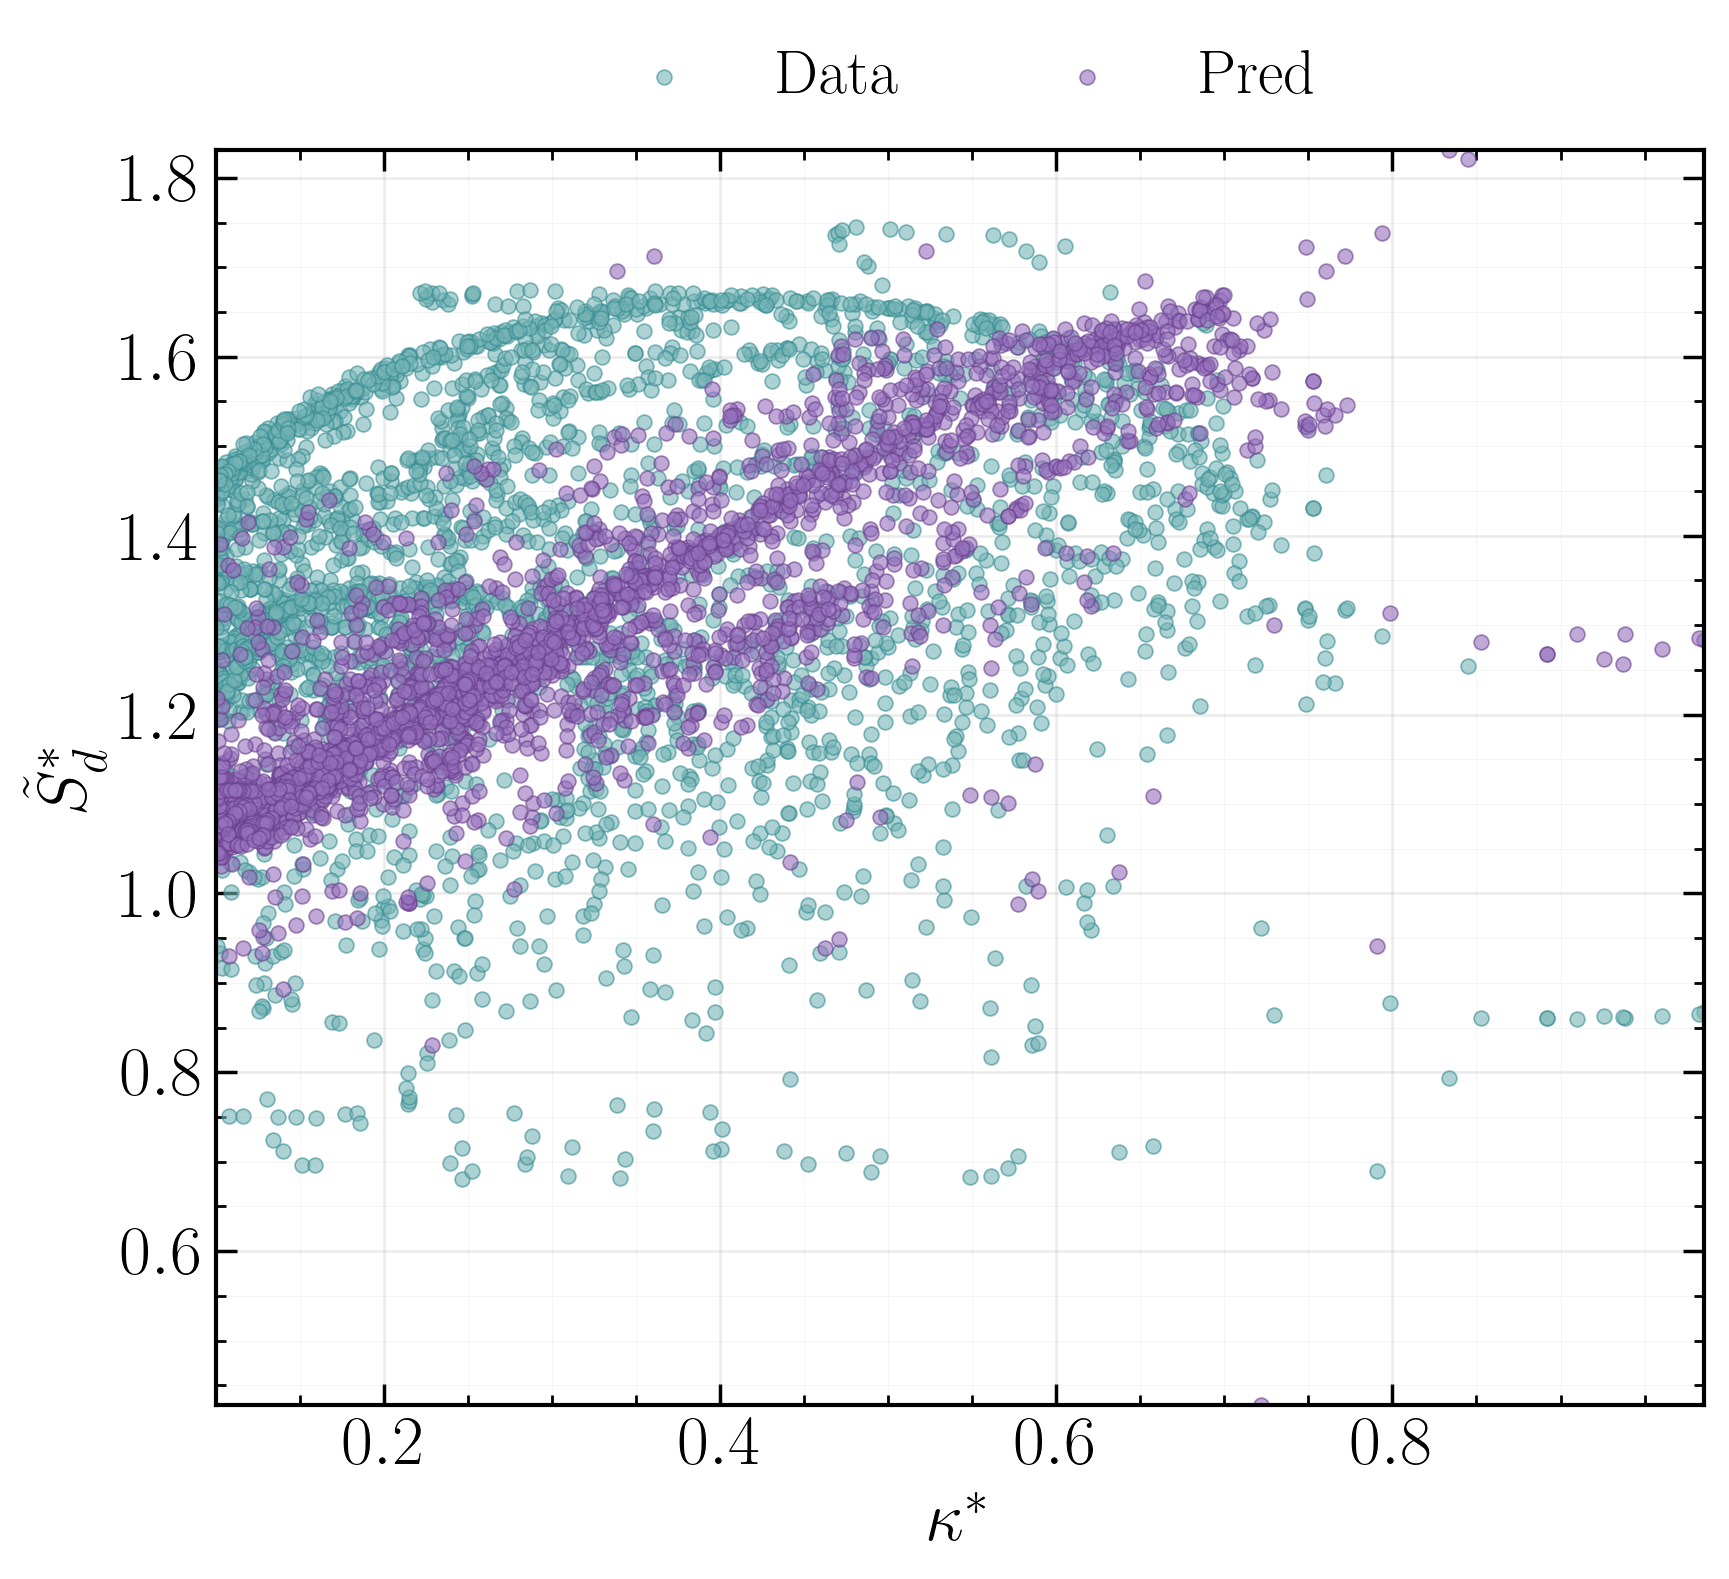

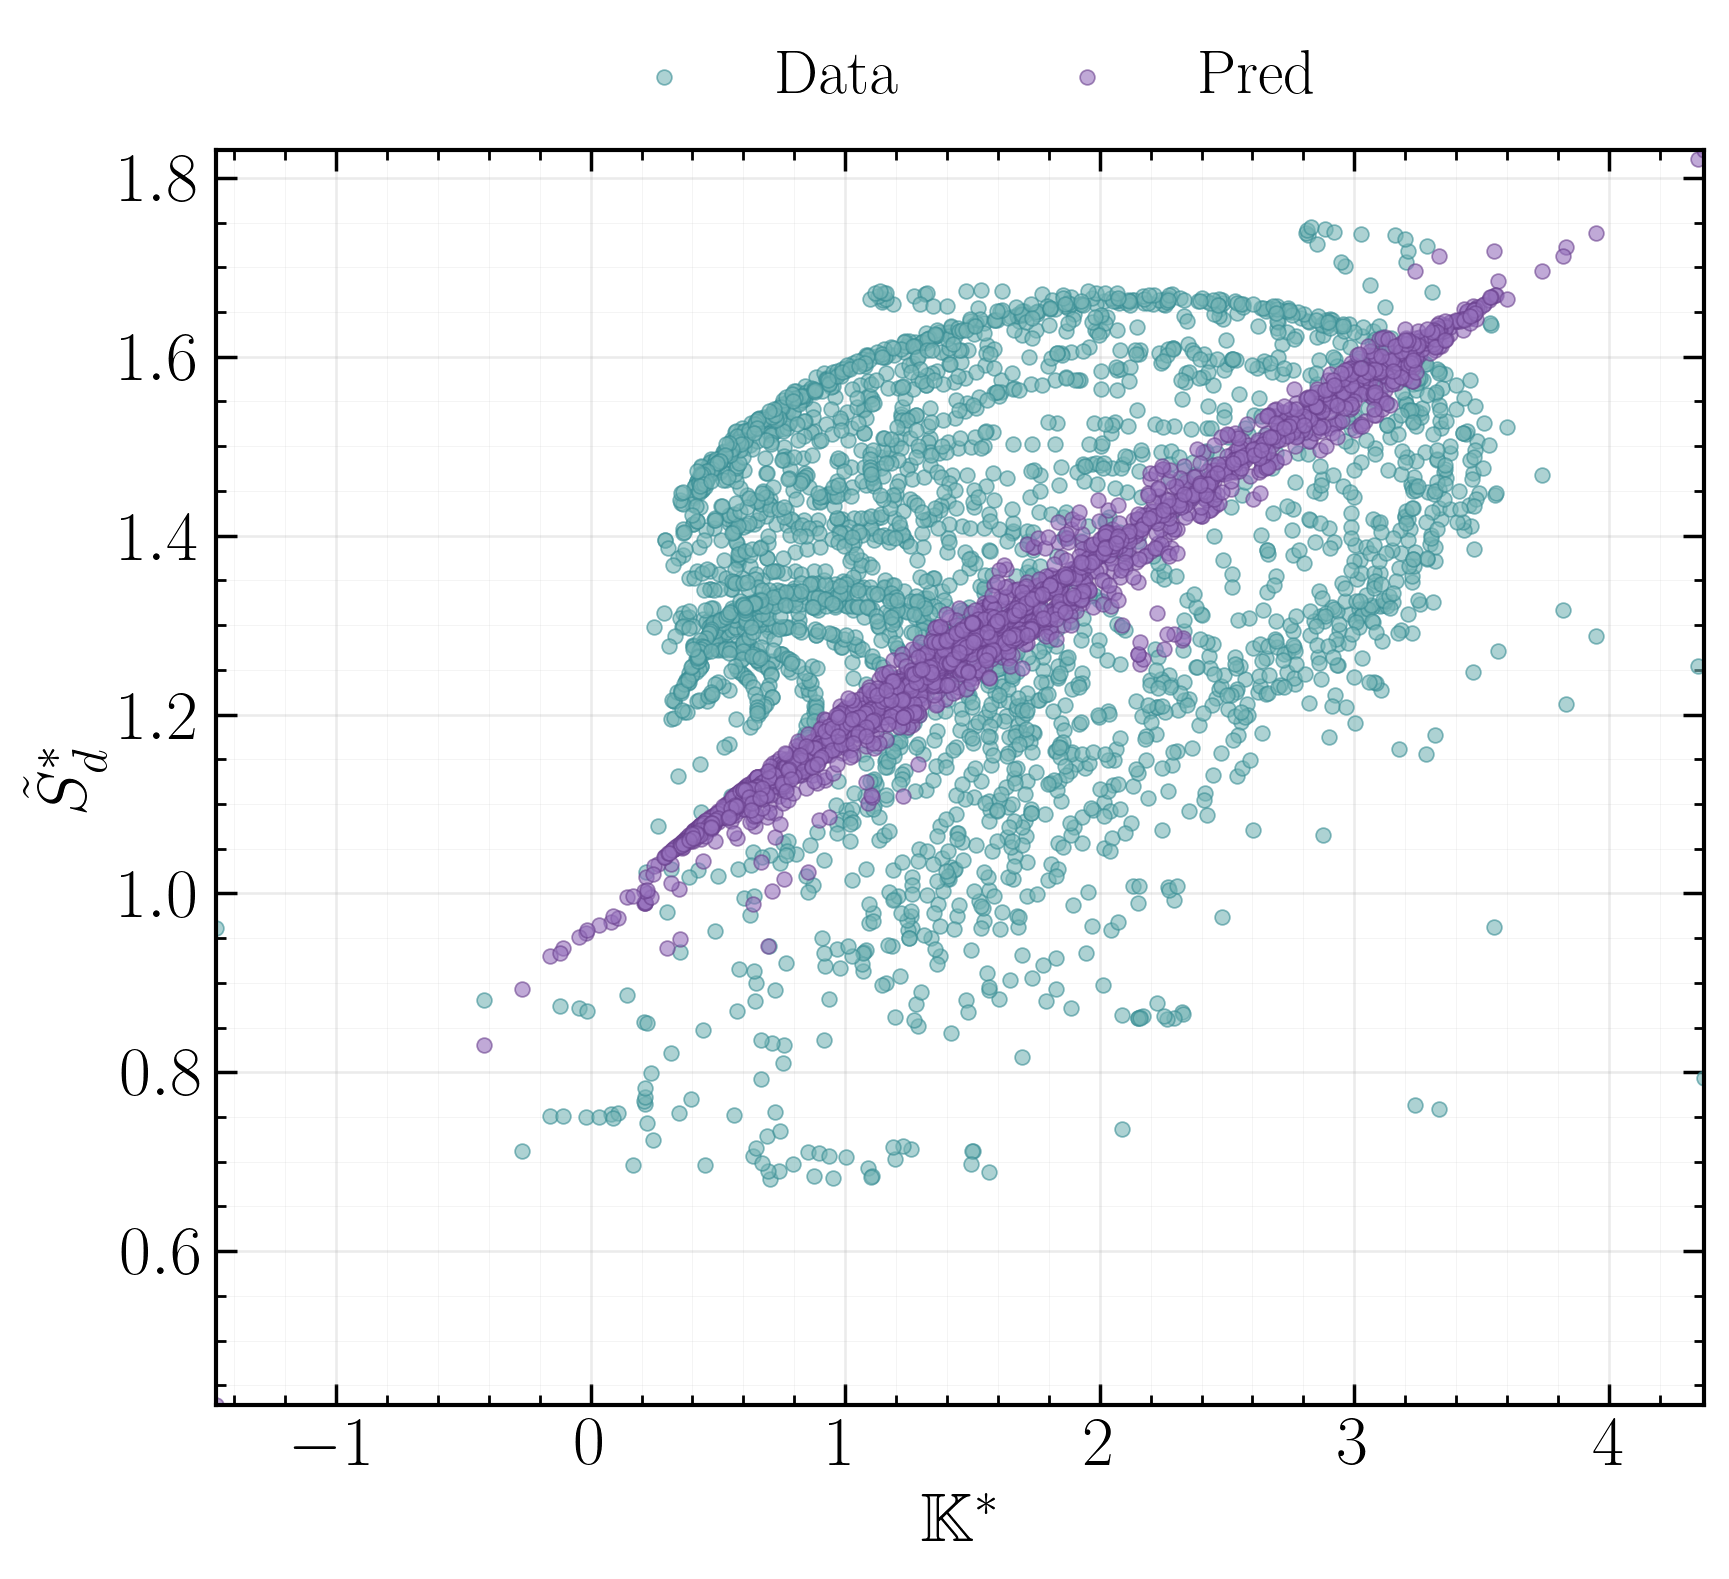

In [12]:
# Joint model plots (shared ranges)
plot_pos_model("joint")


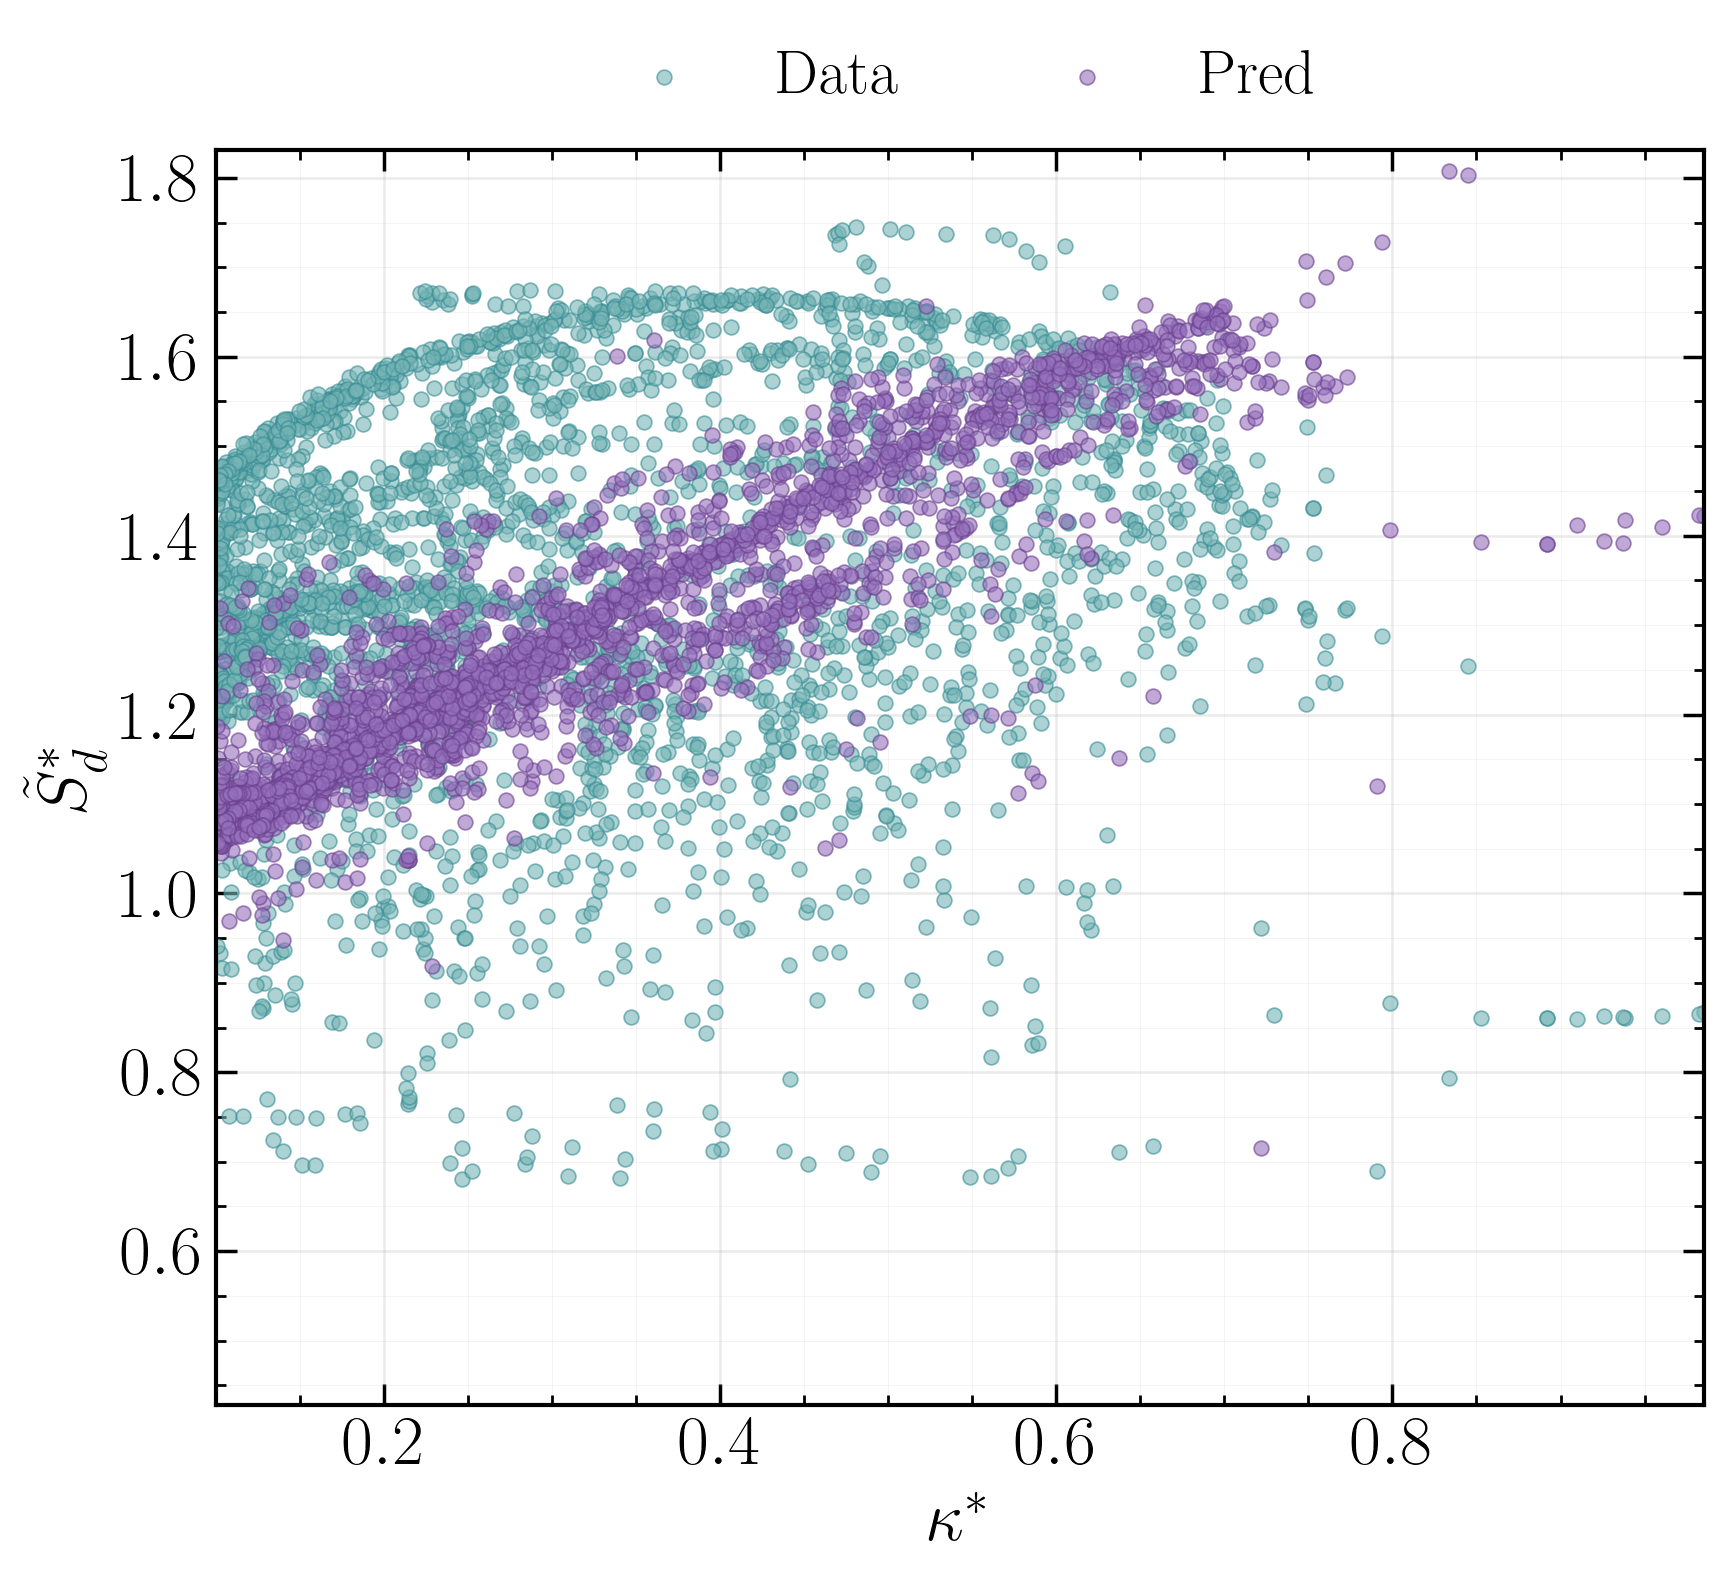

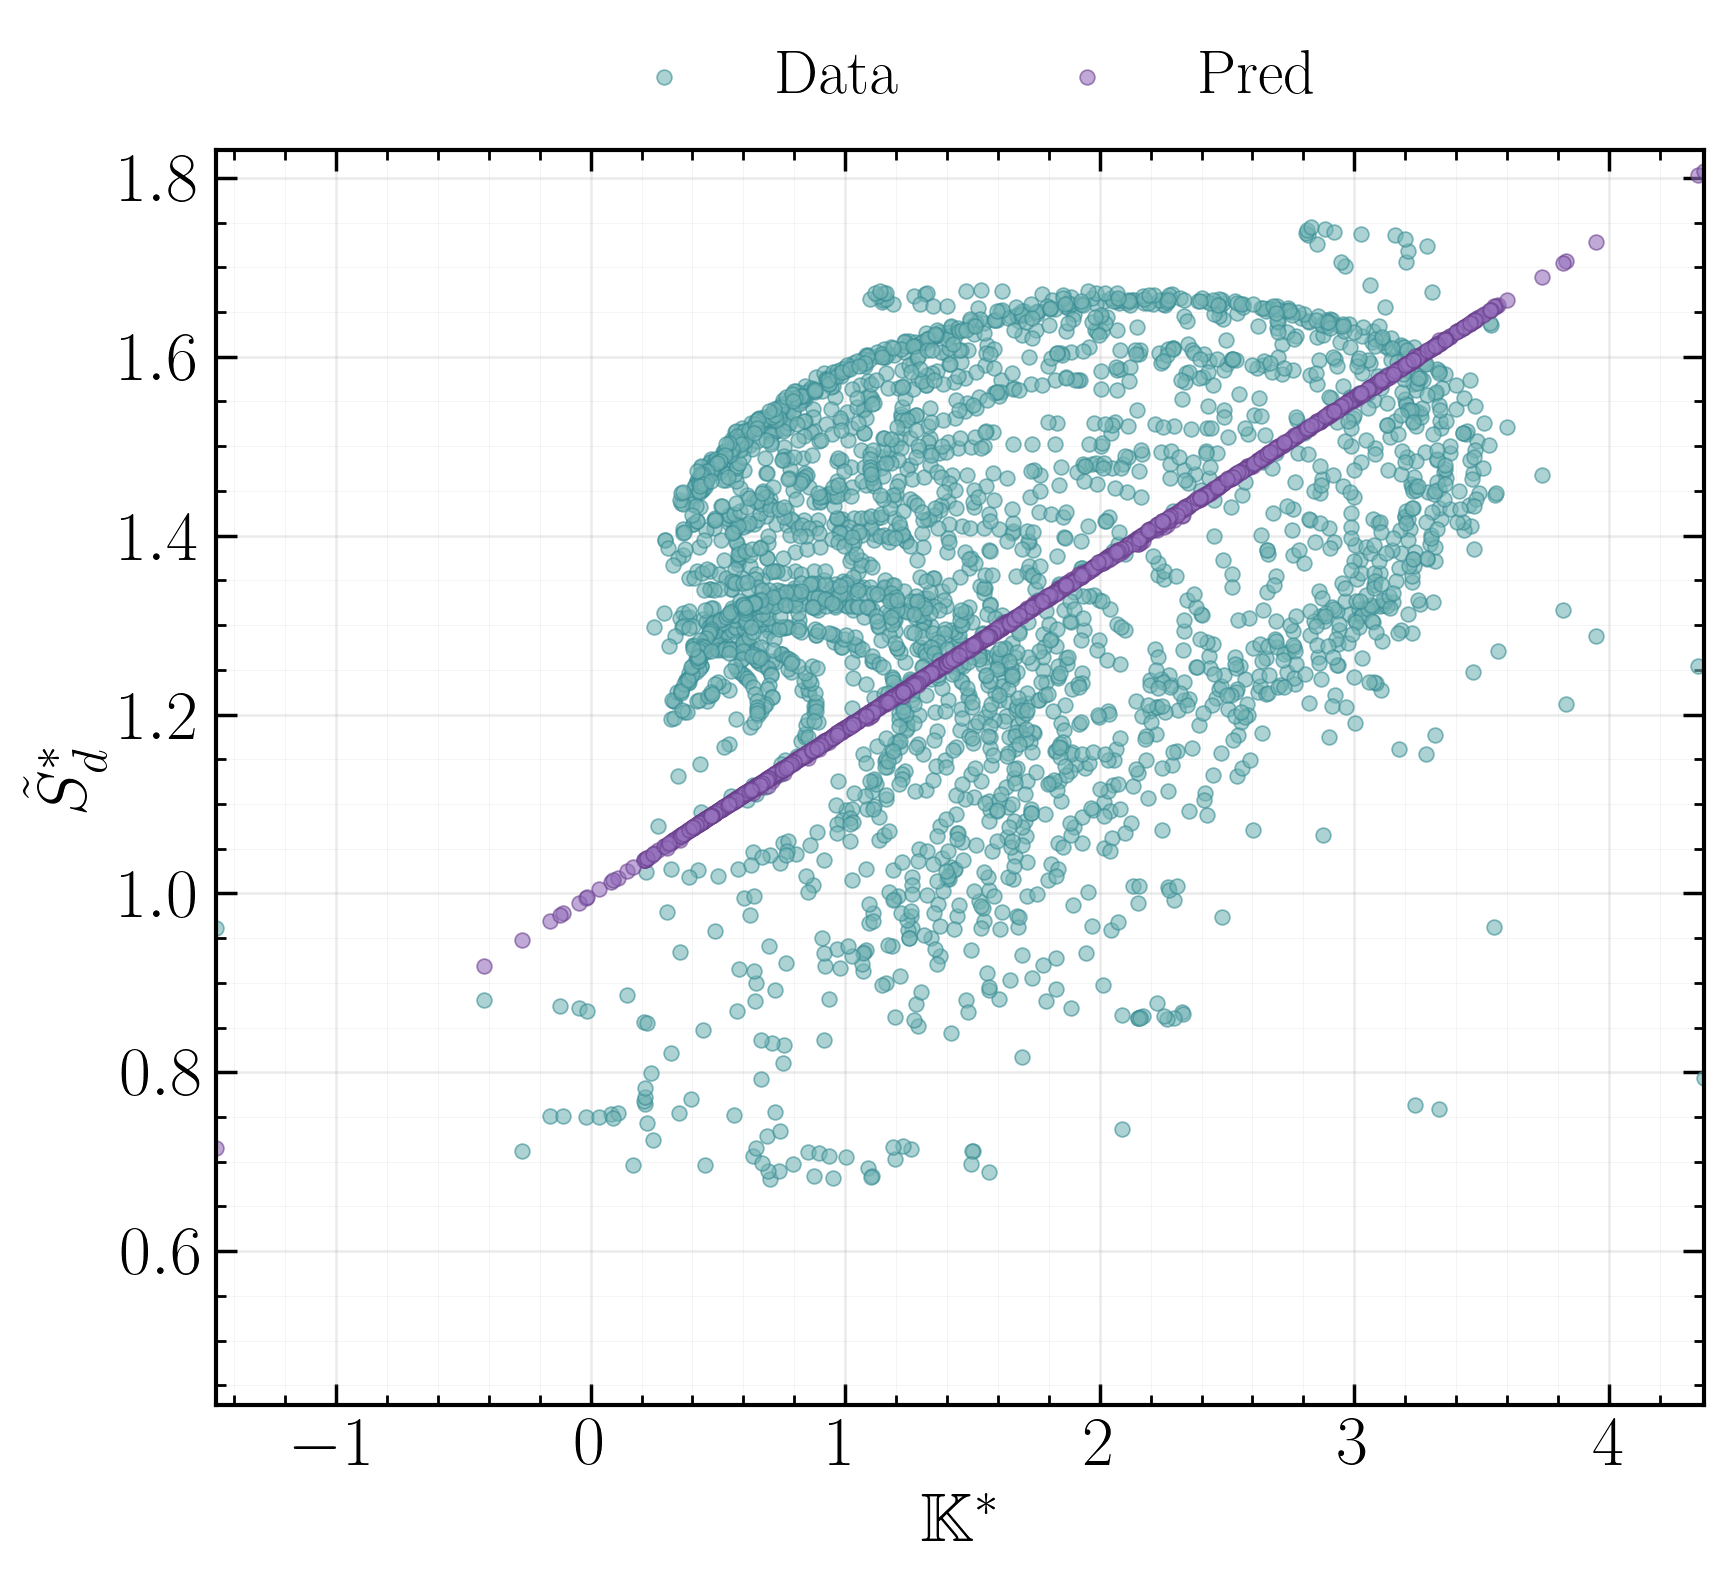

In [13]:
# Sequential model plots (shared ranges)
plot_pos_model("sequential")


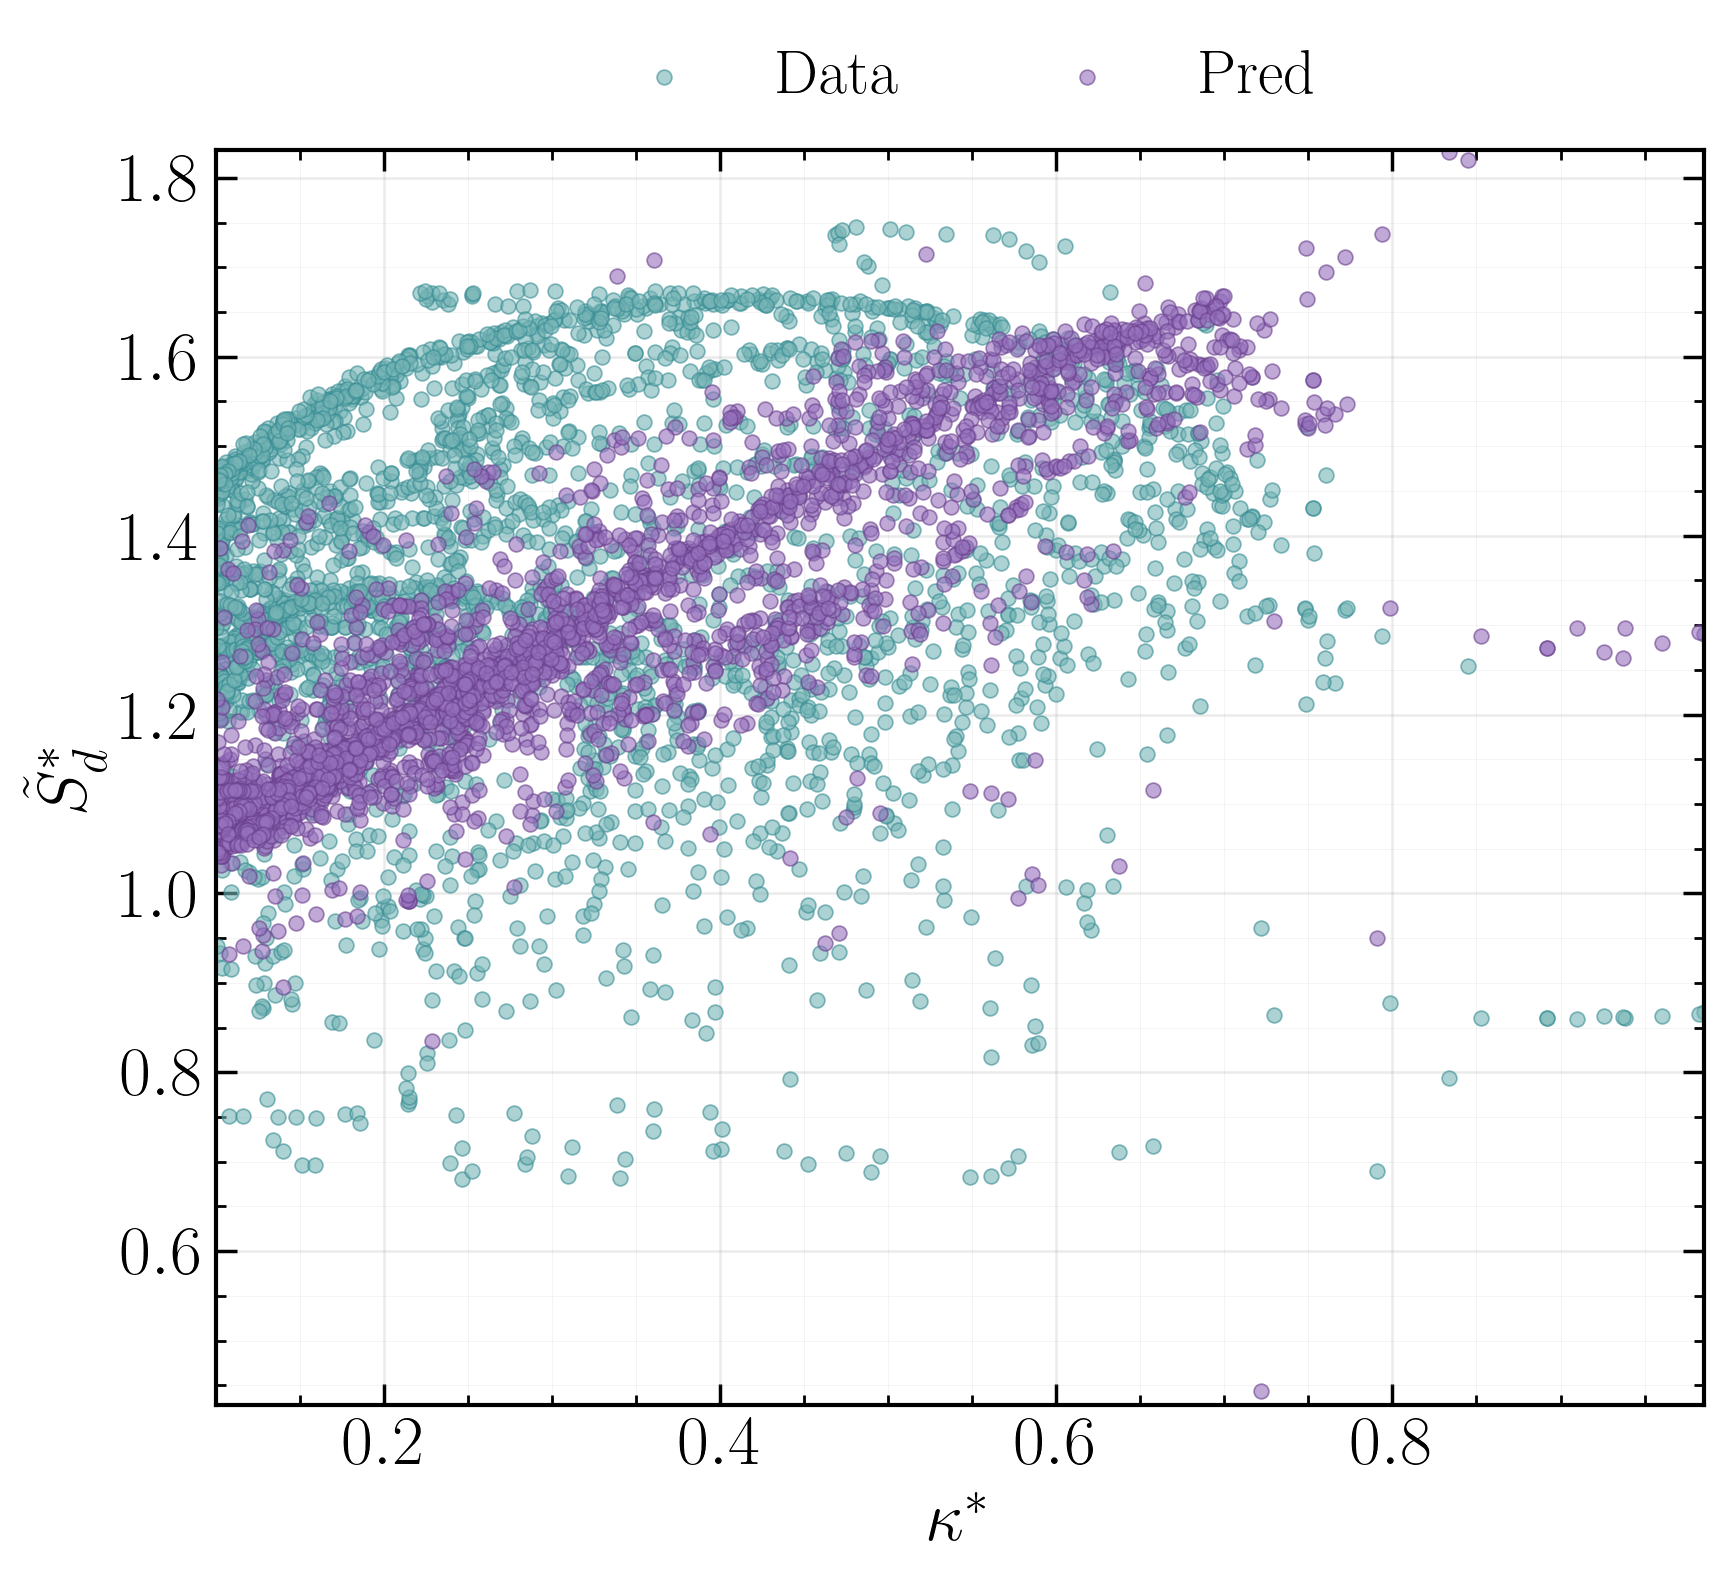

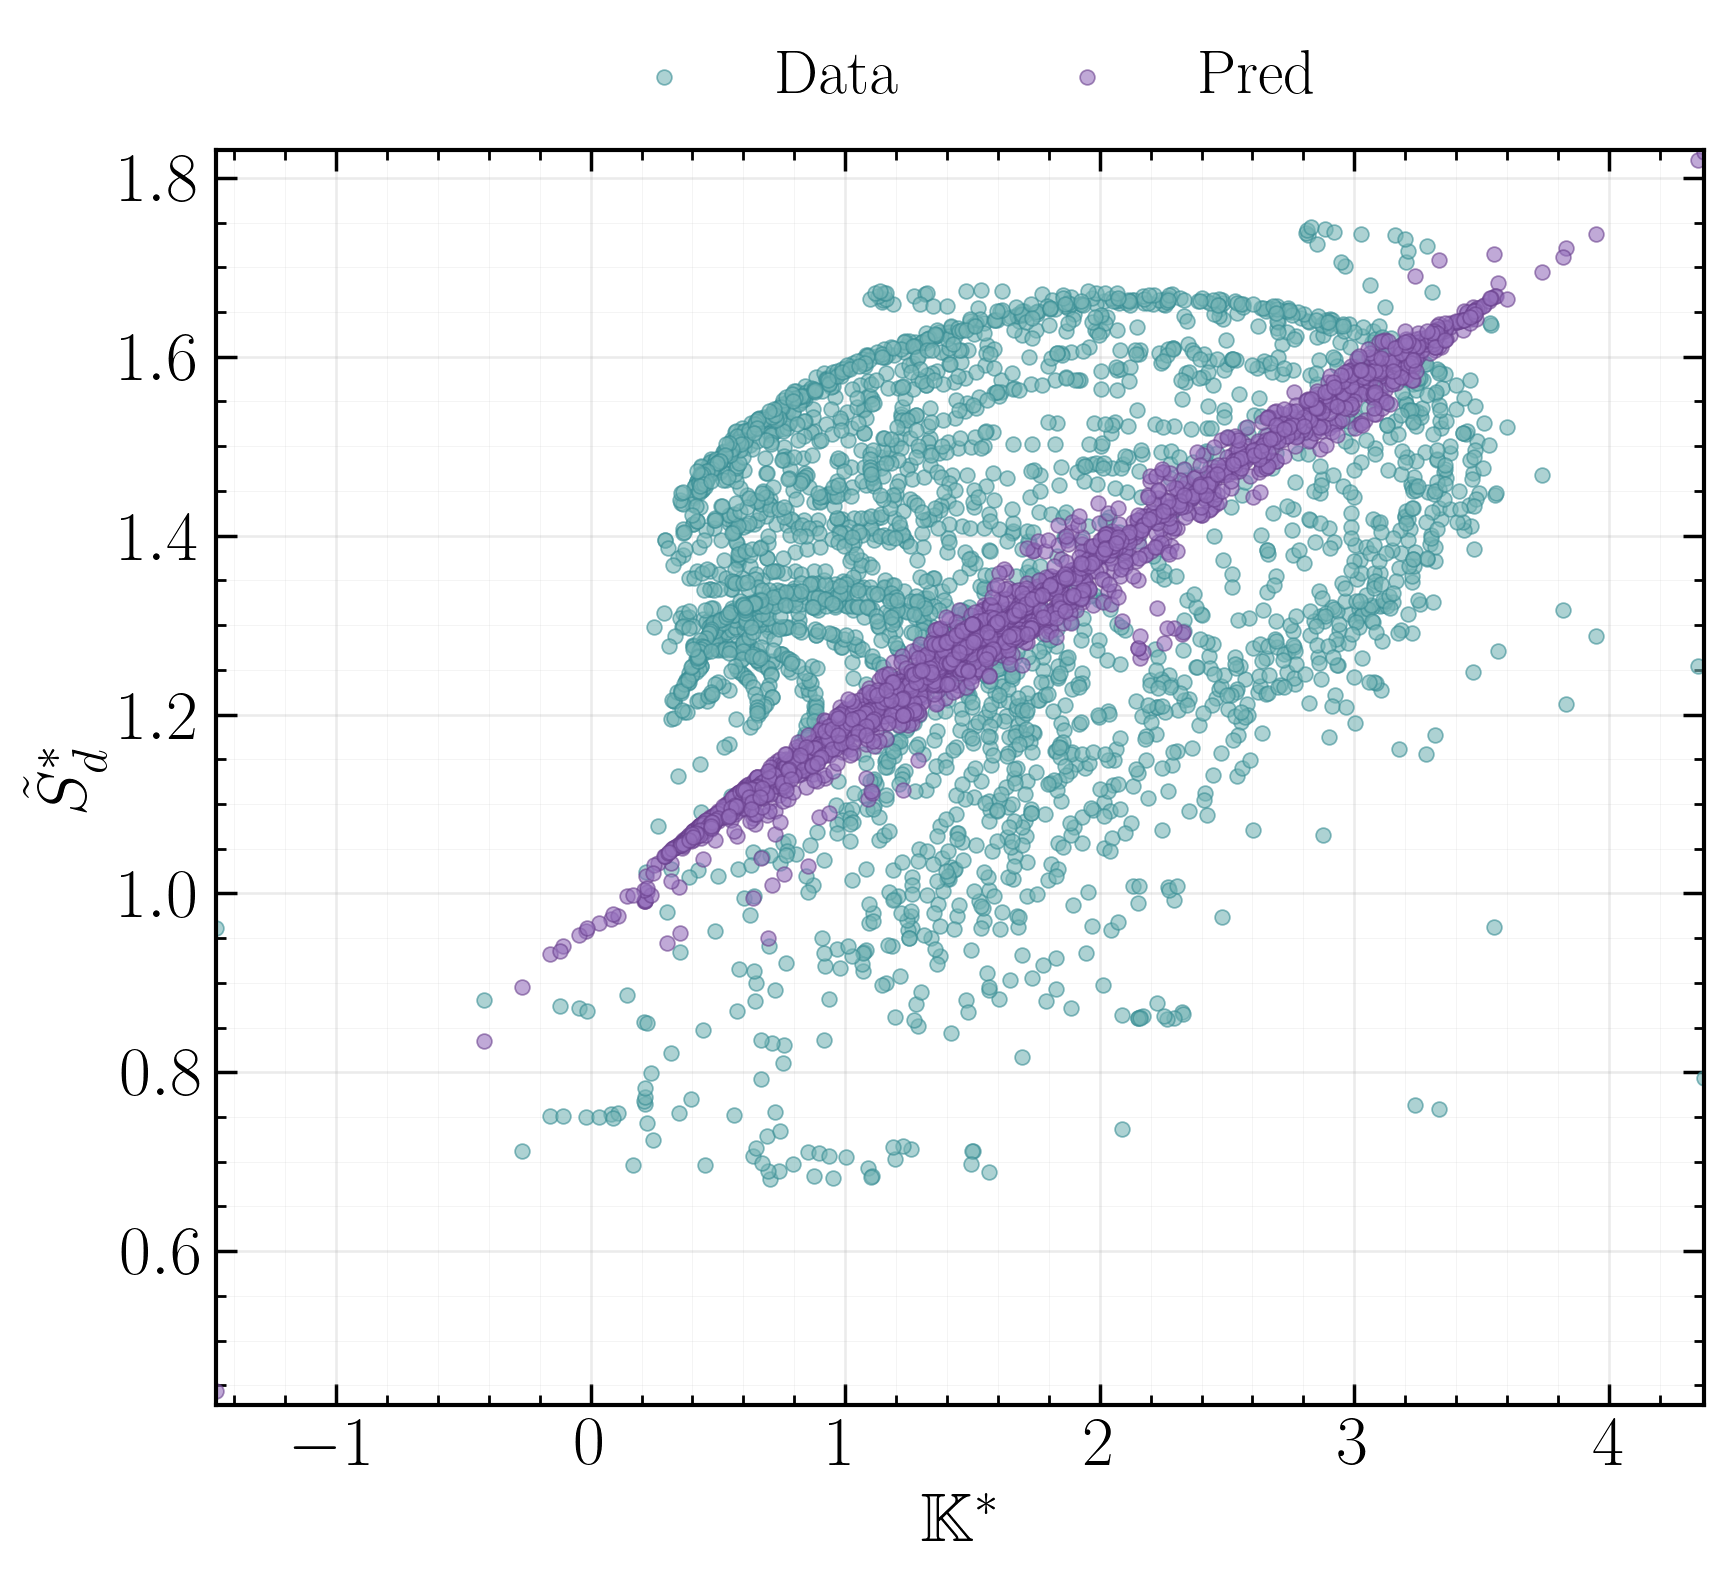

In [14]:
# Huber model plots (shared ranges)
plot_pos_model("huber")


Tabulated Markstein model: predicted vs true.


t=200, T=0.60 (progress=0.6025): Sd = 1 - 1.310e+00*curvature - 1.998e-01*stretch_rate


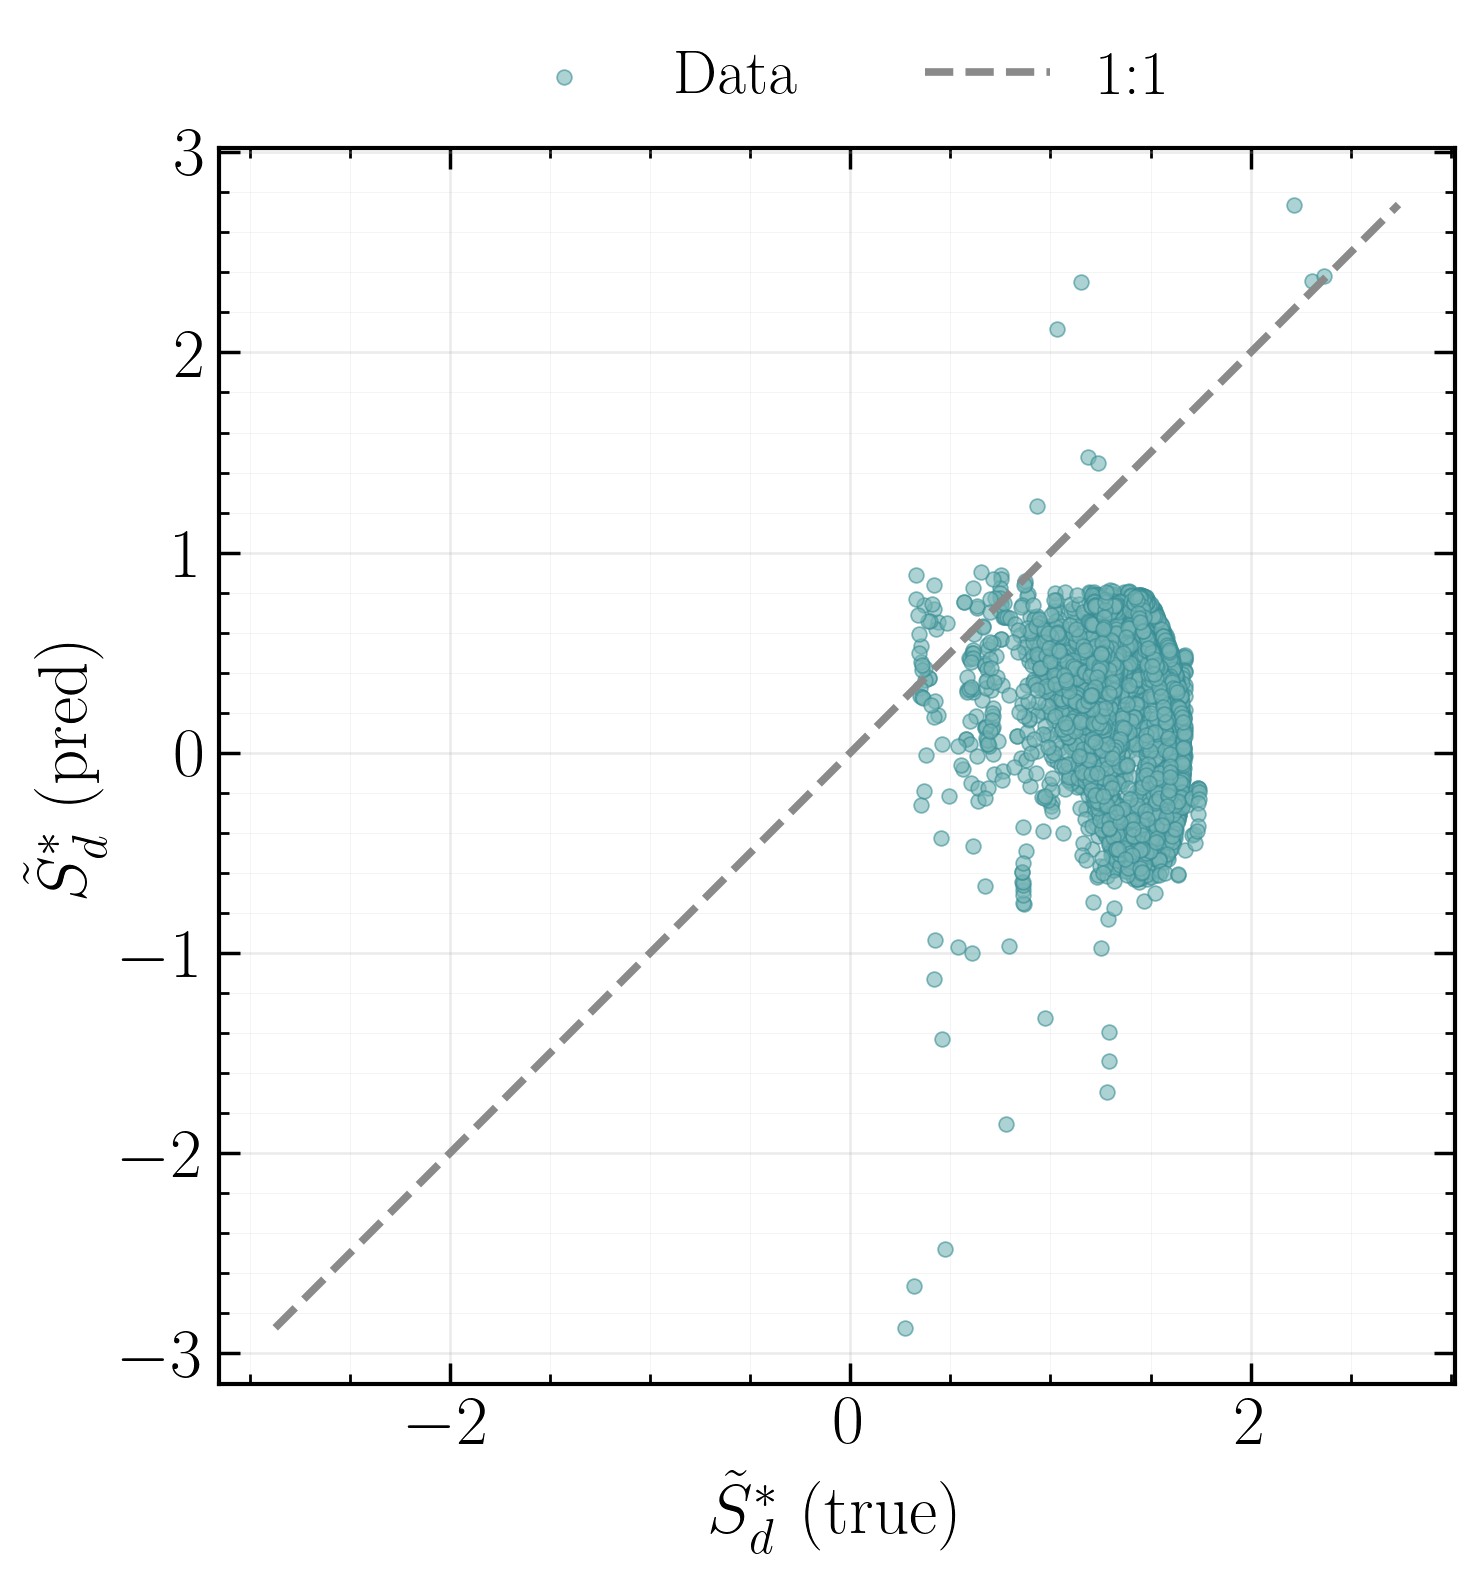

In [15]:
# Positive-curvature model using tabulated Markstein lengths (pred vs true)
import pandas as pd

MARKSTEIN_TABLE_DIR = PROJECT_ROOT / "data" / "Markstein lengths"
MARKSTEIN_TABLES = sorted(MARKSTEIN_TABLE_DIR.glob("markstein_phi_*.csv"))
if not MARKSTEIN_TABLES:
    raise FileNotFoundError(f"No Markstein tables found in {MARKSTEIN_TABLE_DIR}")

phi_tag = f"phi_{PHI:.2f}"
markstein_path = next((p for p in MARKSTEIN_TABLES if phi_tag in p.name), None)
if markstein_path is None:
    markstein_path = MARKSTEIN_TABLES[0]
    print(f"Markstein table for {phi_tag} not found; using {markstein_path.name}")

markstein_df = pd.read_csv(markstein_path)
require_columns(markstein_df, ["progress", "L_cur", "L_str"], context="Markstein table:")


def lookup_markstein_lengths(progress_value: float) -> tuple[float, float, float]:
    diffs = (markstein_df["progress"] - progress_value).abs()
    idx = int(diffs.idxmin())
    row = markstein_df.loc[idx]
    return float(row["L_cur"]), float(row["L_str"]), float(row["progress"])


for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        pos_df = dfv[dfv[CURVATURE_COLUMN] >= CURVATURE_HIGH].copy()
        l_curv, l_str, c_match = lookup_markstein_lengths(float(c_val))
        print(
            f"t={t}, T={float(c_val):.2f} (progress={c_match:.4f}): Sd = 1 - {l_curv:.3e}*curvature - {l_str:.3e}*stretch_rate"
        )

        savepath = None
        if SAVE_FIT_PLOTS:
            out_dir = case_out_dir(t, c_val, FIT_OUT_DIR, "tabulated")
            savepath = out_dir / "tabulated_fit_diagnostics"

        plot_fit_diagnostics(
            pos_df,
            l_curv=l_curv,
            l_str=l_str,
            curv_col=CURVATURE_COLUMN,
            stretch_col=STRETCH_COLUMN,
            target_col=TARGET_COLUMN,
            plot_kind="pred_vs_true",
            savepath=savepath,
        )


Tabulated Markstein model: Sd vs curvature and stretch.


t=200, T=0.60 (progress=0.6025): Sd = 1 - 1.310e+00*curvature - 1.998e-01*stretch_rate


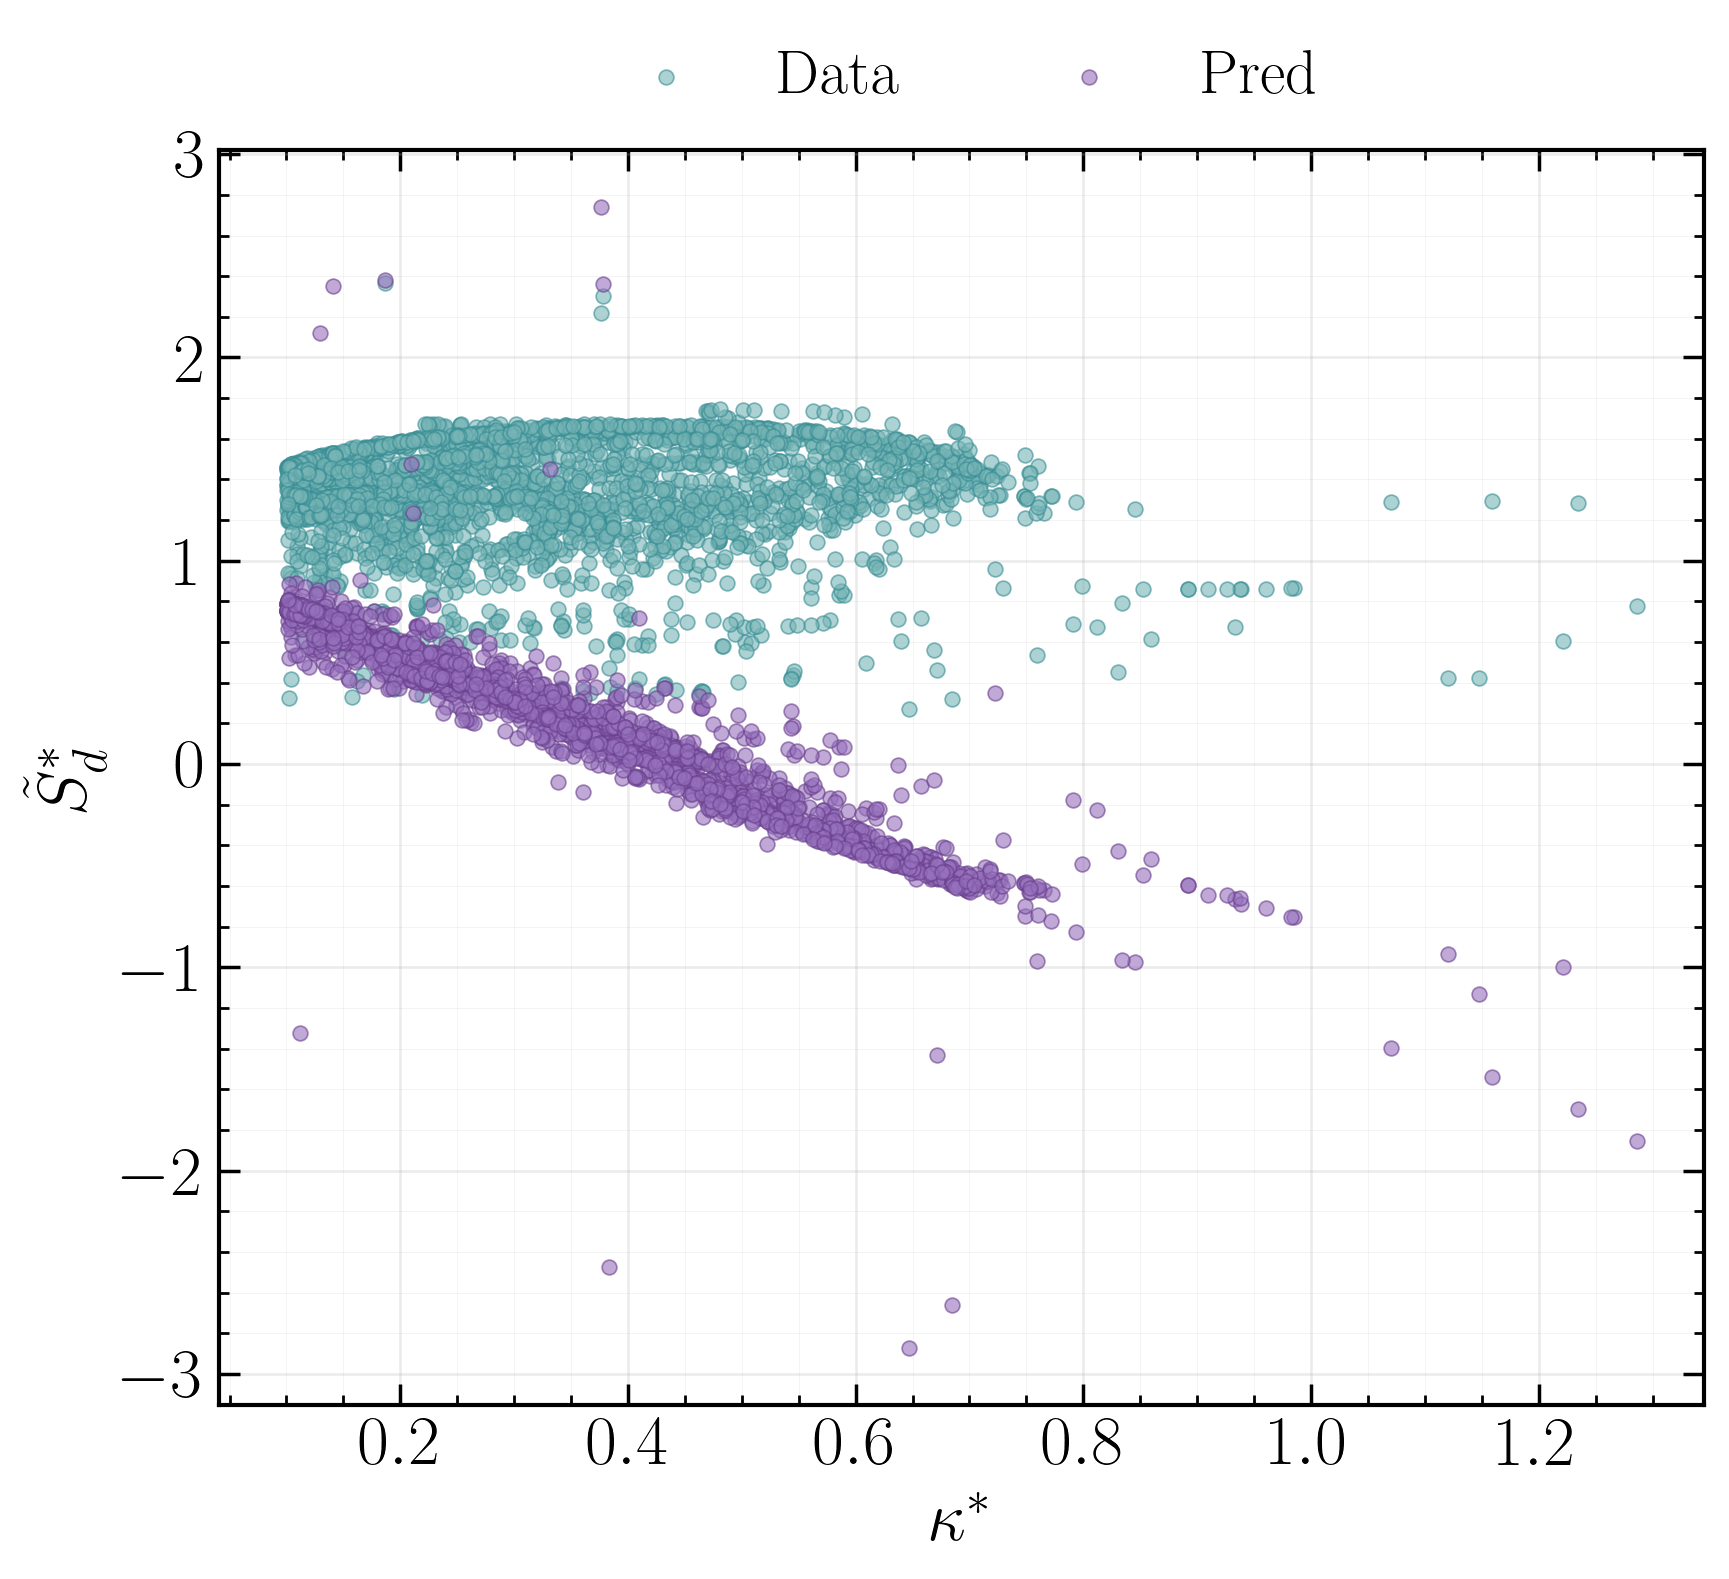

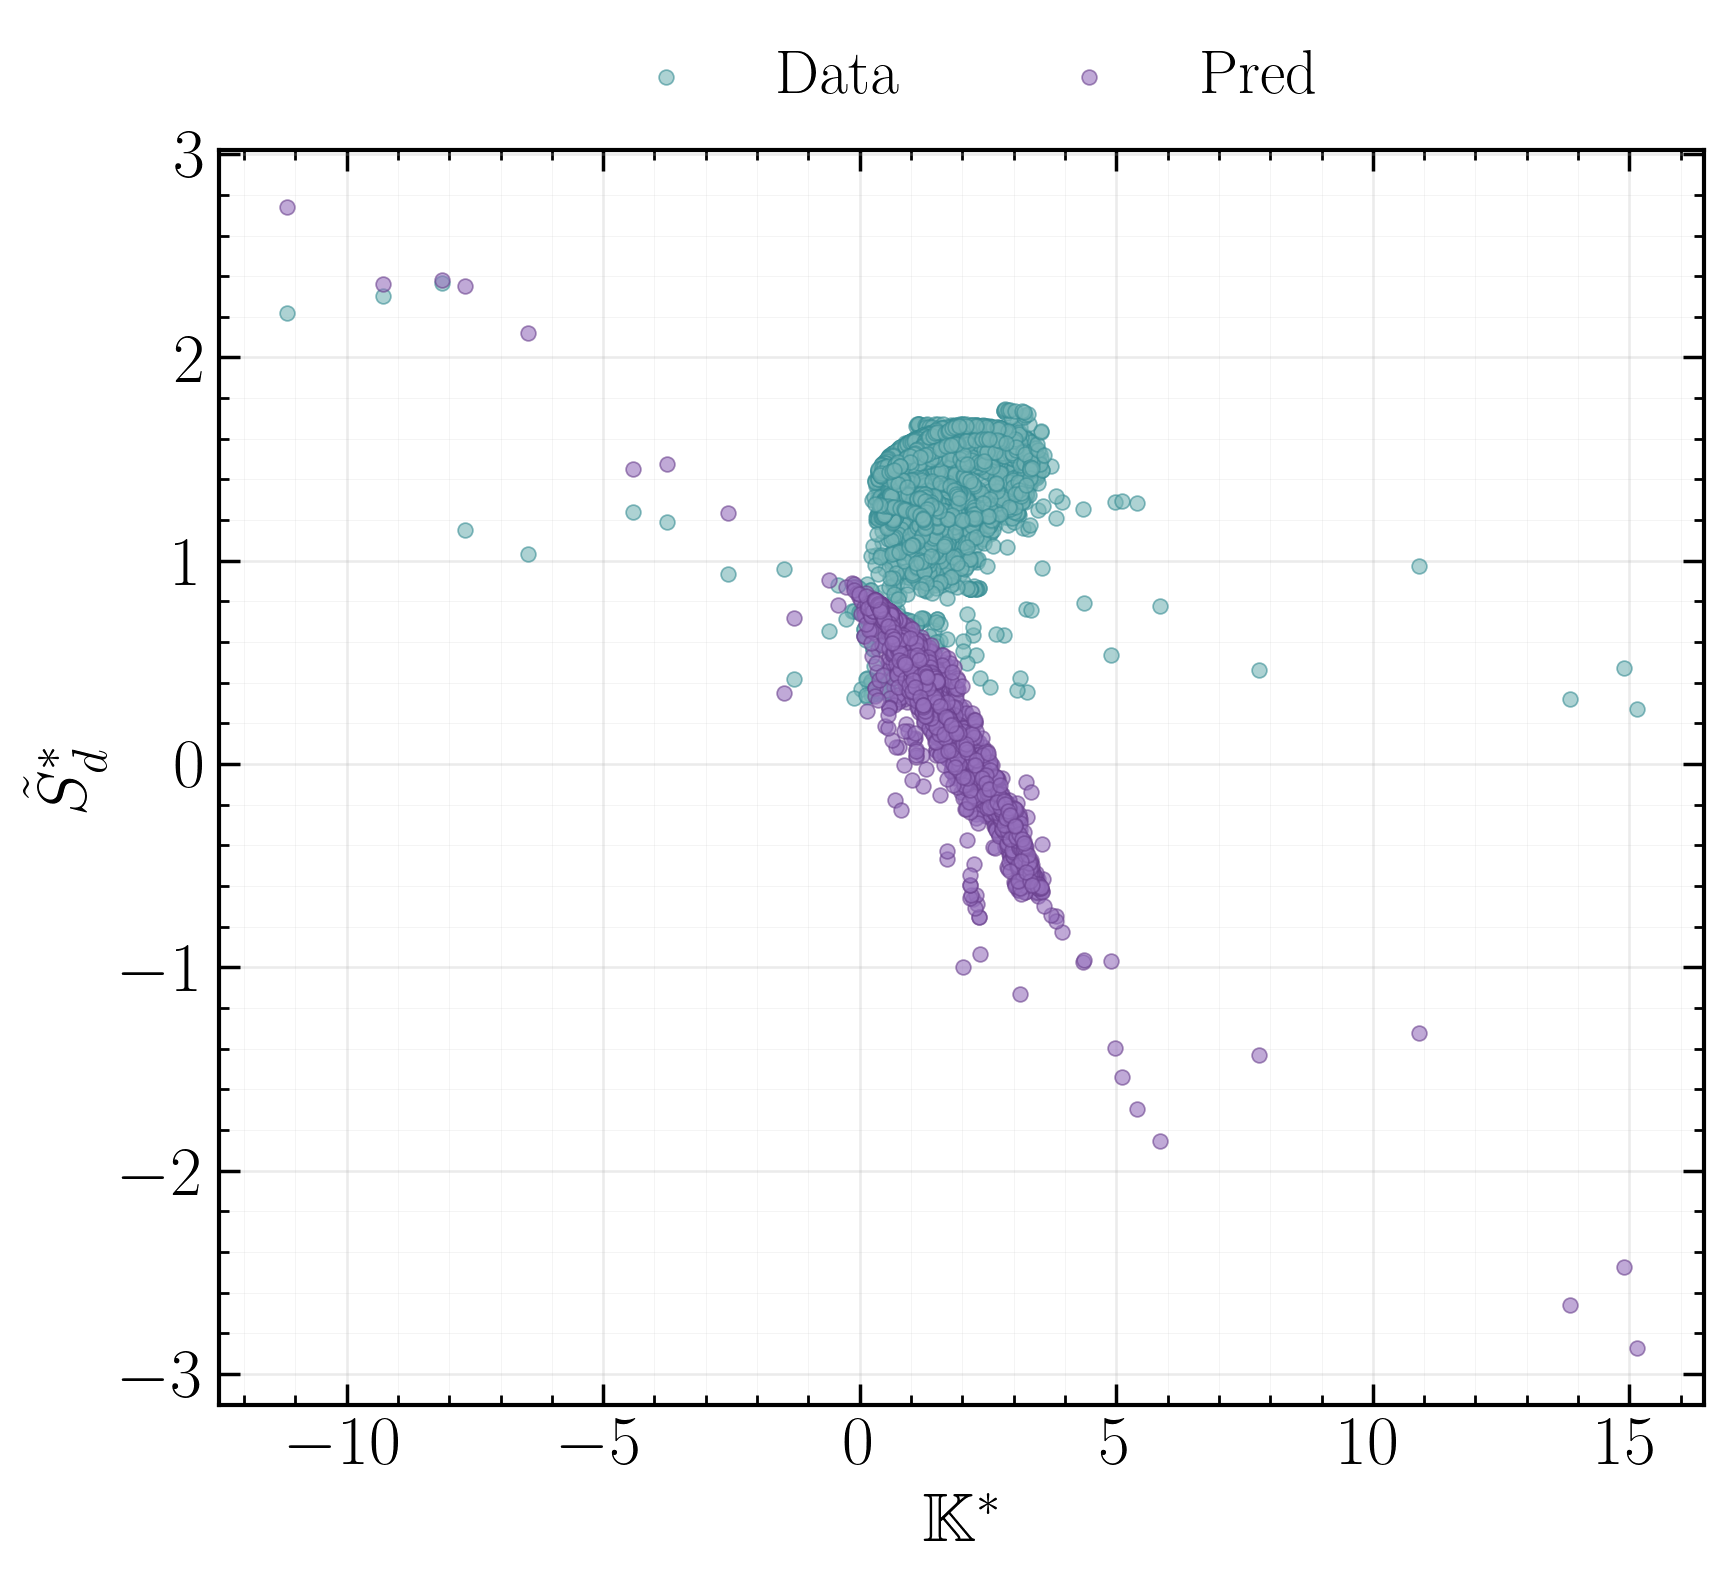

In [16]:
# Positive-curvature model using tabulated Markstein lengths (Sd vs curvature/stretch)
import pandas as pd

MARKSTEIN_TABLE_DIR = PROJECT_ROOT / "data" / "Markstein lengths"
MARKSTEIN_TABLES = sorted(MARKSTEIN_TABLE_DIR.glob("markstein_phi_*.csv"))
if not MARKSTEIN_TABLES:
    raise FileNotFoundError(f"No Markstein tables found in {MARKSTEIN_TABLE_DIR}")

phi_tag = f"phi_{PHI:.2f}"
markstein_path = next((p for p in MARKSTEIN_TABLES if phi_tag in p.name), None)
if markstein_path is None:
    markstein_path = MARKSTEIN_TABLES[0]
    print(f"Markstein table for {phi_tag} not found; using {markstein_path.name}")

markstein_df = pd.read_csv(markstein_path)
require_columns(markstein_df, ["progress", "L_cur", "L_str"], context="Markstein table:")


def lookup_markstein_lengths(progress_value: float) -> tuple[float, float, float]:
    diffs = (markstein_df["progress"] - progress_value).abs()
    idx = int(diffs.idxmin())
    row = markstein_df.loc[idx]
    return float(row["L_cur"]), float(row["L_str"]), float(row["progress"])


for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        pos_df = dfv[dfv[CURVATURE_COLUMN] >= CURVATURE_HIGH].copy()
        l_curv, l_str, c_match = lookup_markstein_lengths(float(c_val))
        print(
            f"t={t}, T={float(c_val):.2f} (progress={c_match:.4f}): Sd = 1 - {l_curv:.3e}*curvature - {l_str:.3e}*stretch_rate"
        )

        savepath = None
        if SAVE_FIT_PLOTS:
            out_dir = case_out_dir(t, c_val, FIT_OUT_DIR, "tabulated")
            savepath = out_dir / "tabulated_fit_diagnostics"

        plot_fit_diagnostics(
            pos_df,
            l_curv=l_curv,
            l_str=l_str,
            curv_col=CURVATURE_COLUMN,
            stretch_col=STRETCH_COLUMN,
            target_col=TARGET_COLUMN,
            plot_kind="sd_vs_curvature",
            savepath=savepath,
        )
        plot_fit_diagnostics(
            pos_df,
            l_curv=l_curv,
            l_str=l_str,
            curv_col=CURVATURE_COLUMN,
            stretch_col=STRETCH_COLUMN,
            target_col=TARGET_COLUMN,
            plot_kind="sd_vs_stretch",
            savepath=savepath,
        )


Negative-curvature model fit (constant C).


In [17]:
# Negative-curvature model check: Sd = 1 - (1/T) * curvature * alpha * (1+C) / (S_L * L_ref)
TARGET_COLUMN = "DW_FDS"
TEMP_COLUMN = "T"
THERMAL_DIFF_COLUMN = "thermal_diffusivity"
S_L_COLUMN = "S_L"
L_REF_COLUMN = "L_ref"

def fit_c_constant(df: pd.DataFrame) -> tuple[float, np.ndarray, float, float]:
    temp = df[TEMP_COLUMN].to_numpy()
    curv = df[CURVATURE_COLUMN].to_numpy()
    alpha = df[THERMAL_DIFF_COLUMN].to_numpy()
    s_l = float(df[S_L_COLUMN].iloc[0])
    l_ref = float(df[L_REF_COLUMN].iloc[0])
    denom = temp * s_l * l_ref
    a = (curv * alpha) / denom
    y_true = df[TARGET_COLUMN].to_numpy()
    y_fit = 1.0 - y_true
    den = float(np.dot(a, a))
    if den <= 0.0:
        raise ValueError("Invalid fit: zero denominator for C regression")
    model = LinearRegression(fit_intercept=False)
    model.fit(a.reshape(-1, 1), y_fit)
    m = float(model.coef_[0])
    c_est = m - 1.0
    y_pred = 1.0 - model.predict(a.reshape(-1, 1))
    ss_res = float(((y_true - y_pred) ** 2).sum())
    ss_tot = float(((y_true - y_true.mean()) ** 2).sum())
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else float("nan")
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    return c_est, y_pred, r2, rmse

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, TEMP_COLUMN, THERMAL_DIFF_COLUMN, S_L_COLUMN, L_REF_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        neg_df = dfv[dfv[CURVATURE_COLUMN] <= CURVATURE_LOW].copy()


        c_est, y_pred, r2, rmse = fit_c_constant(neg_df)
        print(
            f"t={t}, T={float(c_val):.2f}: C={c_est:.3e}, R^2={r2:.3f}, RMSE={rmse:.3e}"
        )


t=200, T=0.60: C=-3.923e-01, R^2=0.563, RMSE=2.864e-01


Negative-curvature diagnostic plot functions.


In [18]:
# Negative-curvature diagnostics plot functions
import matplotlib.pyplot as plt

SAVE_NEG_FIT_PLOTS = True
NEG_FIT_OUT_DIR = "fit_plots"
DIAG_SCATTER_S = 18
DIAG_ALPHA = 0.6
LINE_WIDTH = 2.2
LEGEND_KWARGS = dict(
    frameon=False,
    fontsize=PLOT_FONT_SIZE - 2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.10),
    ncol=2,
    borderaxespad=0.0,
)


def plot_negative_fit_diagnostics(
    df: pd.DataFrame,
    y_pred: np.ndarray,
    plot_kind: str,
    savepath: Path | None = None,
) -> None:
    y_true = df[TARGET_COLUMN].to_numpy()

    if plot_kind == "pred_vs_true":
        fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
        ax.scatter(
            y_true,
            y_pred,
            s=DIAG_SCATTER_S,
            alpha=DIAG_ALPHA,
            color=COLOR_DATA,
            edgecolors=COLOR_DATA_EDGE,
            linewidths=0.5,
            label="Data",
        )
        lim_min = float(min(y_true.min(), y_pred.min()))
        lim_max = float(max(y_true.max(), y_pred.max()))
        ax.plot(
            [lim_min, lim_max],
            [lim_min, lim_max],
            linestyle="--",
            color=COLOR_LINE,
            linewidth=LINE_WIDTH,
            label="1:1",
        )
        ax.set_xlabel(f"{LABEL_SD} (true)")
        ax.set_ylabel(f"{LABEL_SD} (pred)")
        ax.legend(**LEGEND_KWARGS)
        style_axes(ax, equal=True)
        if savepath is not None:
            savepath.parent.mkdir(parents=True, exist_ok=True)
            save_multi_fig(fig, savepath, "pred_vs_true")
        plt.show()
        plt.close(fig)
    elif plot_kind == "sd_vs_curvature":
        fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
        ax.scatter(
            df[CURVATURE_COLUMN],
            y_true,
            s=DIAG_SCATTER_S,
            alpha=DIAG_ALPHA,
            color=COLOR_DATA,
            edgecolors=COLOR_DATA_EDGE,
            linewidths=0.5,
            label="Data",
        )
        ax.scatter(
            df[CURVATURE_COLUMN],
            y_pred,
            s=DIAG_SCATTER_S,
            alpha=DIAG_ALPHA,
            color=COLOR_PRED,
            edgecolors=COLOR_PRED_EDGE,
            linewidths=0.5,
            label="Pred",
        )
        ax.set_xlabel(LABEL_CURV)
        ax.set_ylabel(LABEL_SD)
        ax.legend(**LEGEND_KWARGS)
        style_axes(ax)
        if savepath is not None:
            save_multi_fig(fig, savepath, "sd_vs_curvature")
        plt.show()
        plt.close(fig)
    else:
        raise ValueError(f"Unknown plot_kind: {plot_kind}")


Negative-curvature diagnostics: predicted vs true.


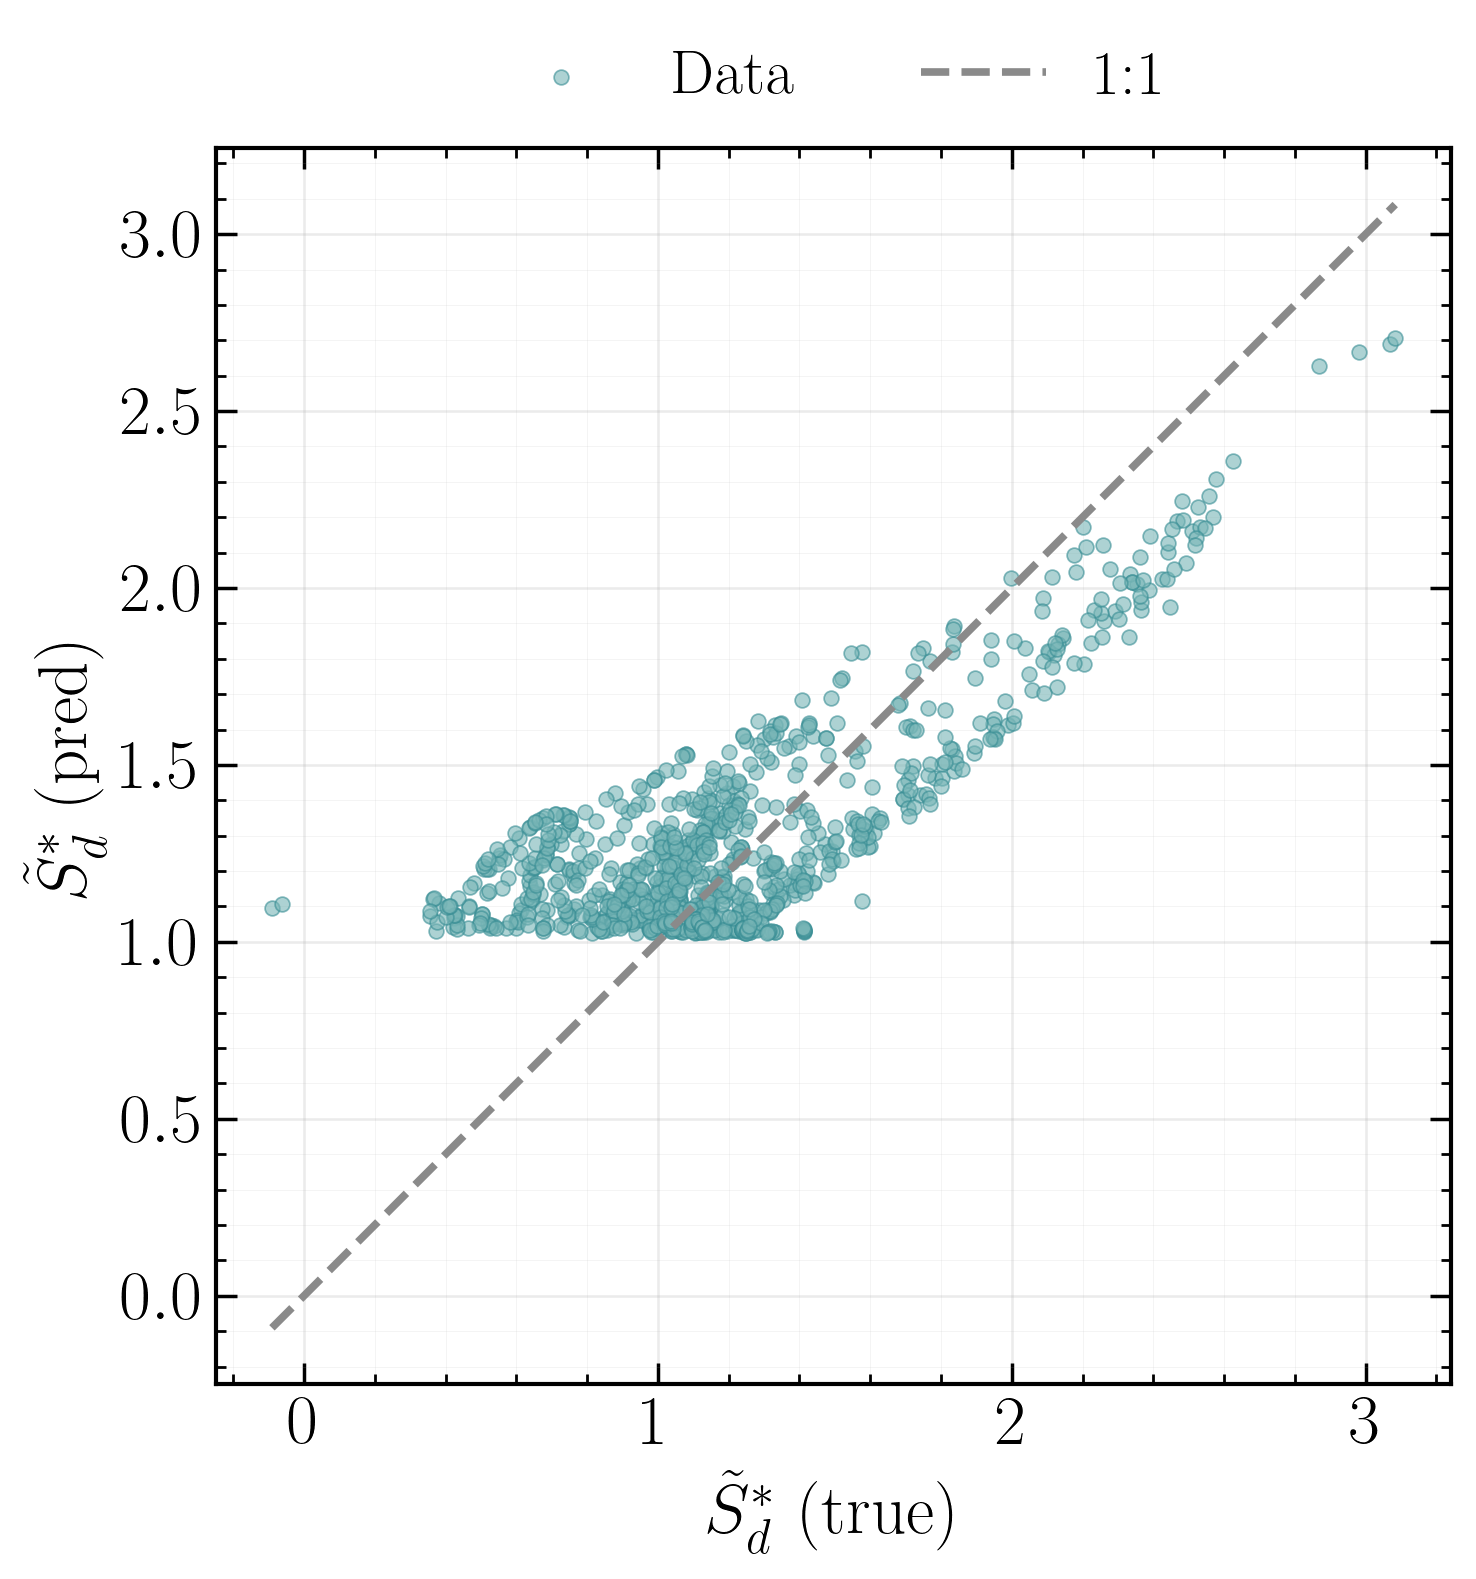

In [19]:
# Negative-curvature diagnostics (pred vs true)
import matplotlib.pyplot as plt

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, TEMP_COLUMN, THERMAL_DIFF_COLUMN, S_L_COLUMN, L_REF_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        neg_df = dfv[dfv[CURVATURE_COLUMN] <= CURVATURE_LOW].copy()

        _, y_pred, _, _ = fit_c_constant(neg_df)
        savepath = None
        if SAVE_NEG_FIT_PLOTS:
            out_dir = case_out_dir(t, c_val, NEG_FIT_OUT_DIR)
            savepath = out_dir / "neg_fit_diagnostics"

        plot_negative_fit_diagnostics(
            neg_df,
            y_pred=y_pred,
            plot_kind="pred_vs_true",
            savepath=savepath,
        )


Negative-curvature diagnostics: Sd vs curvature.


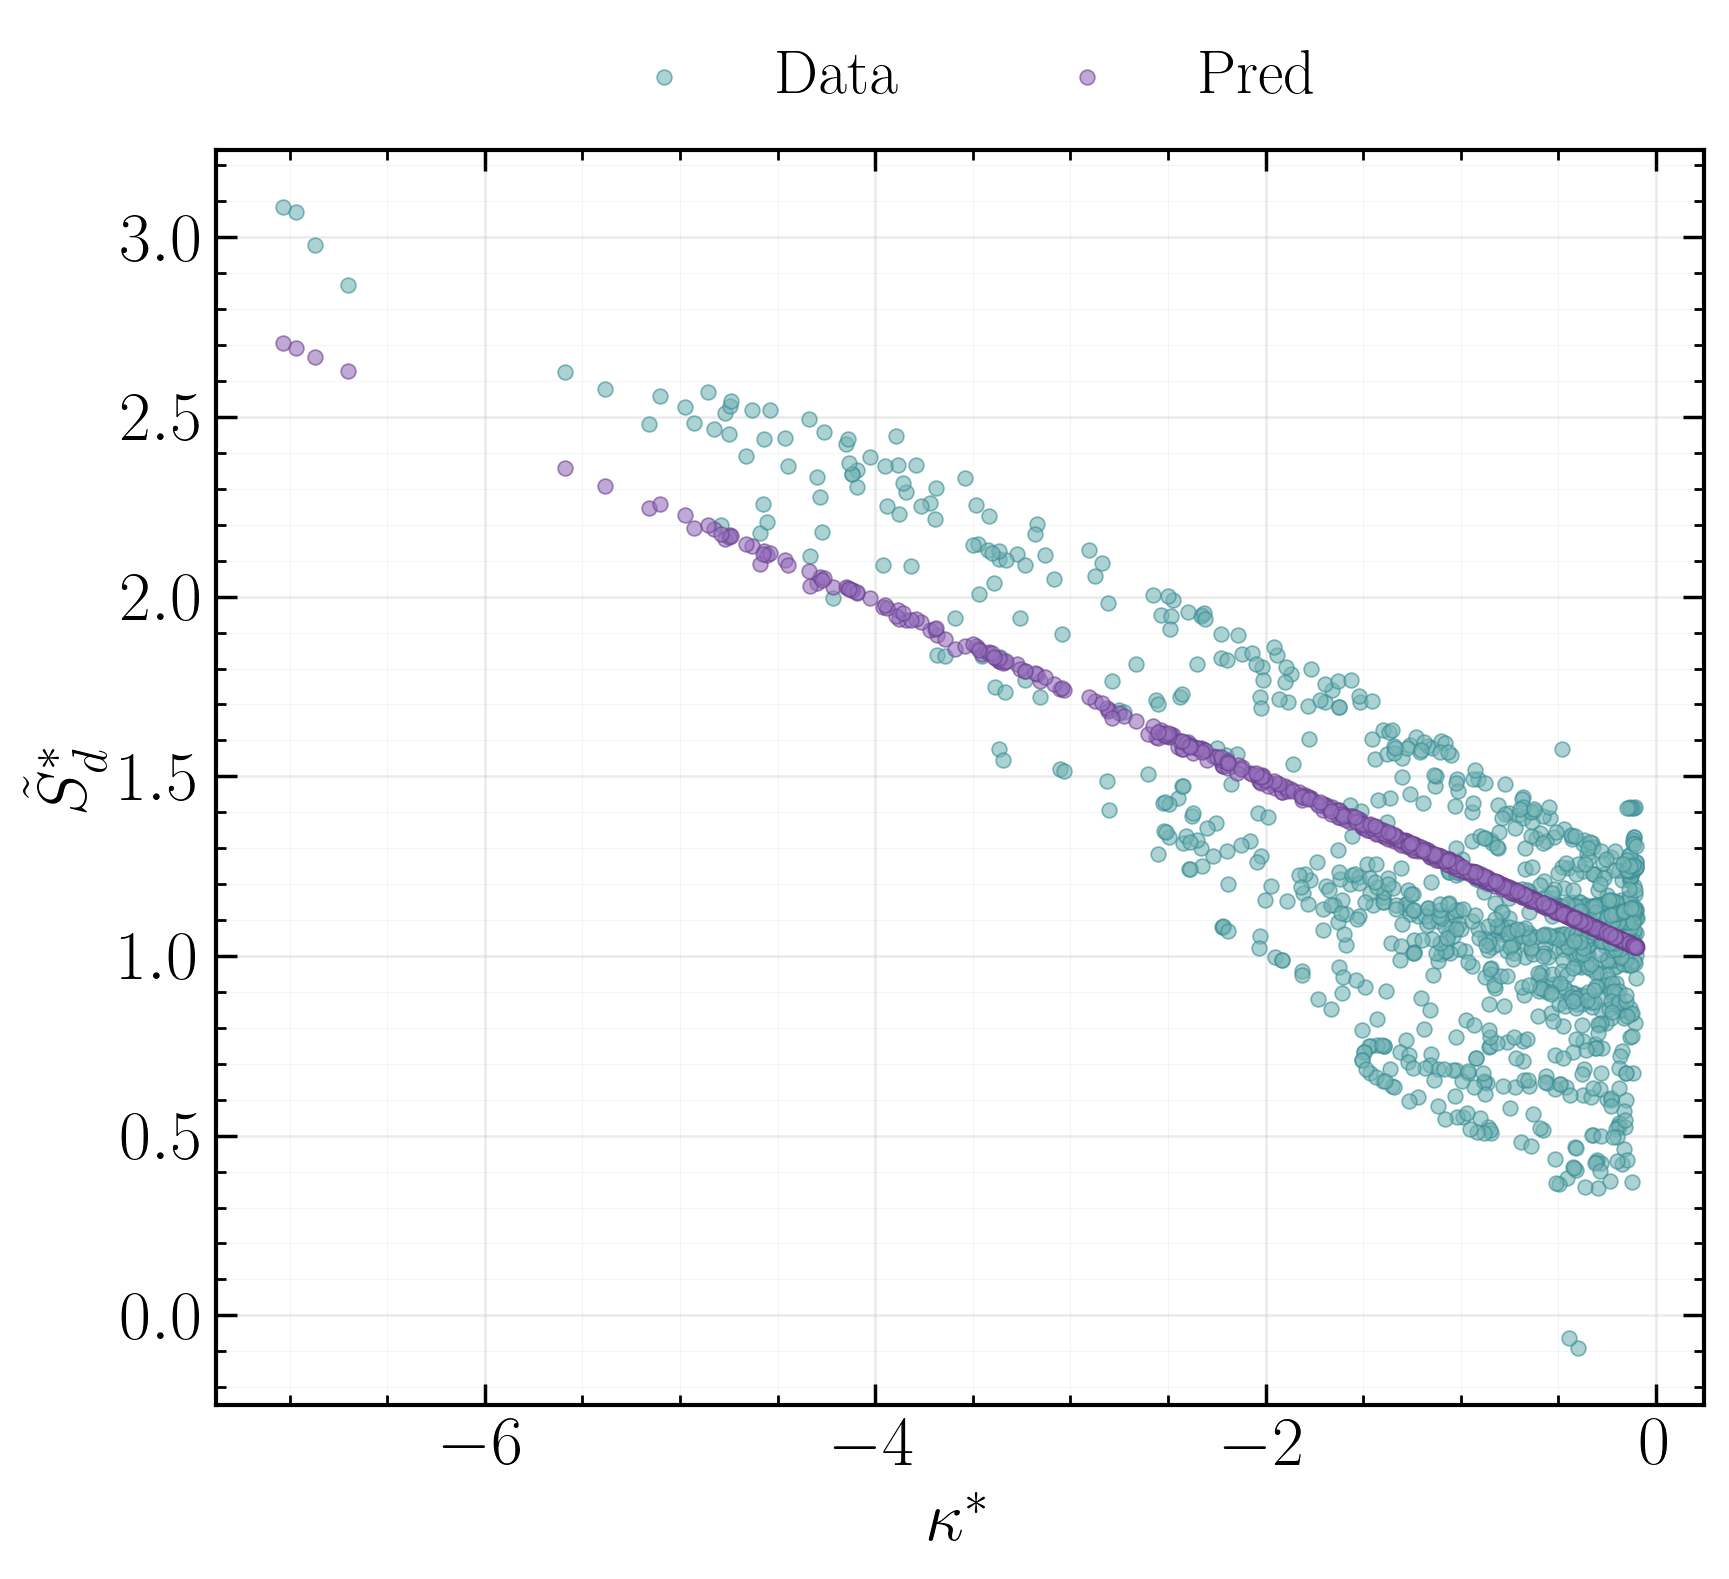

In [20]:
# Negative-curvature diagnostics (Sd vs curvature)
import matplotlib.pyplot as plt

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, TEMP_COLUMN, THERMAL_DIFF_COLUMN, S_L_COLUMN, L_REF_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        neg_df = dfv[dfv[CURVATURE_COLUMN] <= CURVATURE_LOW].copy()

        _, y_pred, _, _ = fit_c_constant(neg_df)
        savepath = None
        if SAVE_NEG_FIT_PLOTS:
            out_dir = case_out_dir(t, c_val, NEG_FIT_OUT_DIR)
            savepath = out_dir / "neg_fit_diagnostics"

        plot_negative_fit_diagnostics(
            neg_df,
            y_pred=y_pred,
            plot_kind="sd_vs_curvature",
            savepath=savepath,
        )


3D interactive fit surface (kept in one cell).


In [21]:
# 3D interactive plot: curvature vs stretch rate vs Sd with fitted surface
import plotly.graph_objects as go

SAVE_PLOTLY_HTML = True
PLOTLY_OUT_DIR = "fit_plots"
MAX_PLOT_POINTS = 20000
SURFACE_N = 60

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        pos_df = dfv[dfv[CURVATURE_COLUMN] >= CURVATURE_HIGH].copy()
        pos_df = apply_outlier_filter(
            pos_df, [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        )

        l_curv, l_str, r2, _ = fit_markstein_lengths(
            pos_df, CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN
        )
        l_curv_seq, l_str_seq, r2_seq, _ = fit_markstein_lengths_sequential(
            pos_df, CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN
        )
        l_curv_tab, l_str_tab, _ = lookup_markstein_lengths(float(c_val))
        l_curv_huber, l_str_huber, _, _ = fit_markstein_lengths_huber(
            pos_df, CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN
        )

        if len(pos_df) > MAX_PLOT_POINTS:
            pos_df = pos_df.sample(MAX_PLOT_POINTS, random_state=42)

        curv = pos_df[CURVATURE_COLUMN].to_numpy()
        stretch = pos_df[STRETCH_COLUMN].to_numpy()
        sd = pos_df[TARGET_COLUMN].to_numpy()
        sd_min, sd_max = float(sd.min()), float(sd.max())

        curv_min, curv_max = float(curv.min()), float(curv.max())
        stretch_min, stretch_max = float(stretch.min()), float(stretch.max())
        curv_grid = np.linspace(curv_min, curv_max, SURFACE_N)
        stretch_grid = np.linspace(stretch_min, stretch_max, SURFACE_N)
        curv_mesh, stretch_mesh = np.meshgrid(curv_grid, stretch_grid)
        sd_mesh = 1.0 - l_curv * curv_mesh - l_str * stretch_mesh
        sd_mesh_seq = 1.0 - l_curv_seq * curv_mesh - l_str_seq * stretch_mesh
        sd_mesh_tab = 1.0 - l_curv_tab * curv_mesh - l_str_tab * stretch_mesh
        sd_mesh_huber = 1.0 - l_curv_huber * curv_mesh - l_str_huber * stretch_mesh

        fig = go.Figure()
        fig.add_trace(
            go.Scatter3d(
                x=curv,
                y=stretch,
                z=sd,
                mode="markers",
                marker=dict(
                    size=2,
                    color=COLOR_DATA,
                    opacity=0.7,
                    line=dict(color=COLOR_DATA_EDGE, width=0.5),
                ),
                name="Data",
            )
        )
        fig.add_trace(
            go.Surface(
                x=curv_mesh,
                y=stretch_mesh,
                z=sd_mesh,
                showlegend=True,
                showscale=False,
                opacity=0.45,
                colorscale=[[0, "#1f77b4"], [1, "#1f77b4"]],
                name="Fit surface (joint)",
            )
        )
        fig.add_trace(
            go.Surface(
                x=curv_mesh,
                y=stretch_mesh,
                z=sd_mesh_seq,
                showlegend=True,
                showscale=False,
                opacity=0.45,
                colorscale=[[0, "#ff7f0e"], [1, "#ff7f0e"]],
                name="Fit surface (sequential)",
            )
        )
        fig.add_trace(
            go.Surface(
                x=curv_mesh,
                y=stretch_mesh,
                z=sd_mesh_tab,
                showlegend=True,
                showscale=False,
                opacity=0.45,
                colorscale=[[0, "#2ca02c"], [1, "#2ca02c"]],
                name="Fit surface (tabulated)",
            )
        )
        fig.add_trace(
            go.Surface(
                x=curv_mesh,
                y=stretch_mesh,
                z=sd_mesh_huber,
                showlegend=True,
                showscale=False,
                opacity=0.45,
                colorscale=[[0, "#d62728"], [1, "#d62728"]],
                name="Fit surface (huber)",
            )
        )

        fig.update_layout()
import matplotlib.pyplot as plt

PLOT_FONT_FAMILY = str(CFG.get("PLOT_FONT_FAMILY", "Courier New"))
PLOT_FONT_SIZE = int(CFG.get("PLOT_FONT_SIZE", 20))
FIG_DPI = int(CFG.get("FIG_DPI", 250))
FIG_SIZE_RAW = CFG.get("FIG_SIZE", (6.8, 6.2))
if isinstance(FIG_SIZE_RAW, (list, tuple)) and len(FIG_SIZE_RAW) == 2:
    FIG_SIZE = (float(FIG_SIZE_RAW[0]), float(FIG_SIZE_RAW[1]))
else:
    FIG_SIZE = (6.8, 6.2)

PLOT_USE_TEX = bool(CFG.get("PLOT_USE_TEX", False))
PLOT_TEX_PREAMBLE_RAW = CFG.get("PLOT_TEX_PREAMBLE", "")
if isinstance(PLOT_TEX_PREAMBLE_RAW, (list, tuple)):
    PLOT_TEX_PREAMBLE = "\n".join(str(item) for item in PLOT_TEX_PREAMBLE_RAW if item)
else:
    PLOT_TEX_PREAMBLE = str(PLOT_TEX_PREAMBLE_RAW) if PLOT_TEX_PREAMBLE_RAW is not None else ""

def apply_plot_style() -> None:
    params = {
        "font.family": PLOT_FONT_FAMILY,
        "font.size": PLOT_FONT_SIZE,
        "axes.titlesize": PLOT_FONT_SIZE,
        "axes.labelsize": PLOT_FONT_SIZE,
        "xtick.labelsize": PLOT_FONT_SIZE,
        "ytick.labelsize": PLOT_FONT_SIZE,
        "legend.fontsize": PLOT_FONT_SIZE,
        "figure.titlesize": PLOT_FONT_SIZE,
        "axes.linewidth": 1.2,
        "text.usetex": PLOT_USE_TEX,
    }
    if PLOT_TEX_PREAMBLE:
        params["text.latex.preamble"] = PLOT_TEX_PREAMBLE
    plt.rcParams.update(params)

apply_plot_style()

COLOR_DATA = str(CFG.get("COLOR_DATA", "#77b5b6"))
COLOR_DATA_EDGE = str(CFG.get("COLOR_DATA_EDGE", "#378d94"))
COLOR_PRED = str(CFG.get("COLOR_PRED", "#9671bd"))
COLOR_PRED_EDGE = str(CFG.get("COLOR_PRED_EDGE", "#6a408d"))
COLOR_NEUTRAL = str(CFG.get("COLOR_NEUTRAL", "#7e7e7e"))
COLOR_LINE = str(CFG.get("COLOR_LINE", "#8a8a8a"))

LABEL_CURV = r"$\kappa^*$"
LABEL_STRETCH = r"$\mathbb{K}^*$"
LABEL_SD = r"$\tilde{S}_d^*$"






Summary metrics for positive-curvature models.


In [22]:
# Summary: positive-curvature fit accuracy (R^2, RMSE) for all models
summary_rows = []

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        pos_df = dfv[dfv[CURVATURE_COLUMN] >= CURVATURE_HIGH].copy()
        pos_df = apply_outlier_filter(
            pos_df, [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN]
        )

        curv = pos_df[CURVATURE_COLUMN].to_numpy()
        stretch = pos_df[STRETCH_COLUMN].to_numpy()
        y_true = pos_df[TARGET_COLUMN].to_numpy()

        l_curv, l_str, r2_joint, rmse_joint = fit_markstein_lengths(
            pos_df, CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN
        )
        l_curv_seq, l_str_seq, r2_seq, rmse_seq = fit_markstein_lengths_sequential(
            pos_df, CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN
        )
        l_curv_huber, l_str_huber, r2_huber, rmse_huber = fit_markstein_lengths_huber(
            pos_df, CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN
        )
        l_curv_tab, l_str_tab, _ = lookup_markstein_lengths(float(c_val))

        y_pred_tab = 1.0 - (l_curv_tab * curv + l_str_tab * stretch)
        ss_res_tab = float(((y_true - y_pred_tab) ** 2).sum())
        ss_tot_tab = float(((y_true - y_true.mean()) ** 2).sum())
        r2_tab = 1.0 - ss_res_tab / ss_tot_tab if ss_tot_tab > 0 else float("nan")
        rmse_tab = float(np.sqrt(np.mean((y_true - y_pred_tab) ** 2)))

        summary_rows.append({
            "time_step": t,
            "progress": float(c_val),
            "model": "joint",
            "R2": r2_joint,
            "RMSE": rmse_joint,
            "L_curv": l_curv,
            "L_str": l_str,
        })
        summary_rows.append({
            "time_step": t,
            "progress": float(c_val),
            "model": "sequential",
            "R2": r2_seq,
            "RMSE": rmse_seq,
            "L_curv": l_curv_seq,
            "L_str": l_str_seq,
        })
        summary_rows.append({
            "time_step": t,
            "progress": float(c_val),
            "model": "huber",
            "R2": r2_huber,
            "RMSE": rmse_huber,
            "L_curv": l_curv_huber,
            "L_str": l_str_huber,
        })
        summary_rows.append({
            "time_step": t,
            "progress": float(c_val),
            "model": "tabulated",
            "R2": r2_tab,
            "RMSE": rmse_tab,
            "L_curv": l_curv_tab,
            "L_str": l_str_tab,
        })

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(["time_step", "progress", "model"]).reset_index(drop=True)
display(summary_df)


time_step  progress       model         R2      RMSE    L_curv     L_str
0        200       0.6       huber  -0.378285  0.241656  0.276429 -0.242219
1        200       0.6       joint  -0.378250  0.241653  0.291535 -0.245485
2        200       0.6  sequential  -0.389098  0.242602  0.012541 -0.186986
3        200       0.6   tabulated -31.605327  1.175365  1.309548  0.199766

[BLEND] t=200, T=0.60: L_curv=2.915e-01, L_str=-2.455e-01, C=-3.923e-01 | R^2(all)=-0.257, RMSE(all)=3.056e-01


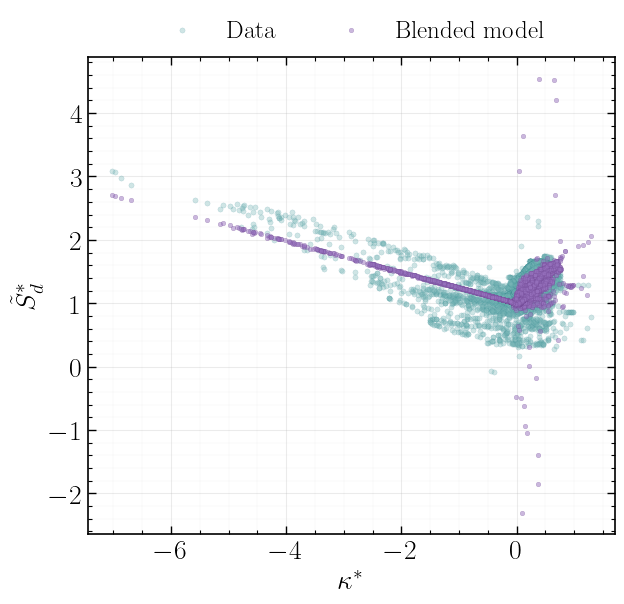

In [27]:
# ============================================================
# Blended curvature-transition model:
#   - Positive-curvature joint regression: Sd = 1 - L_curv*kappa - L_str*K
#   - Negative-curvature C-model:         Sd = 1 - (1+C) * (kappa*alpha)/(T*S_L*L_ref)
#   - Blend between them based on curvature (smoothstep from CURVATURE_LOW -> CURVATURE_HIGH)
# Then plot predictions vs data over the FULL curvature range.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# (Re)declare column names used by both models (keeps this cell robust)
TARGET_COLUMN = "DW_FDS"
STRETCH_COLUMN = "stretch_rate"
TEMP_COLUMN = "T"
THERMAL_DIFF_COLUMN = "thermal_diffusivity"
S_L_COLUMN = "S_L"
L_REF_COLUMN = "L_ref"


def smoothstep_weight(kappa: np.ndarray, low: float, high: float) -> np.ndarray:
    """
    Returns w in [0,1]:
      w=0 for kappa<=low
      w=1 for kappa>=high
      smooth C1 transition in between
    """
    u = (kappa - low) / (high - low)
    u = np.clip(u, 0.0, 1.0)
    return u * u * (3.0 - 2.0 * u)


def r2_rmse(y_true: np.ndarray, y_pred: np.ndarray) -> tuple[float, float]:
    ss_res = float(np.sum((y_true - y_pred) ** 2))
    ss_tot = float(np.sum((y_true - np.mean(y_true)) ** 2))
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else float("nan")
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    return r2, rmse


# If you already defined these in earlier cells, this will reuse them;
# otherwise it provides minimal local fallbacks.
if "fit_markstein_lengths" not in globals():

    def fit_markstein_lengths(
        df: pd.DataFrame,
        curv_col: str,
        stretch_col: str,
        target_col: str,
    ) -> tuple[float, float, float, float]:
        X = df[[curv_col, stretch_col]].to_numpy()
        y_true = df[target_col].to_numpy()
        y_fit = 1.0 - y_true
        model = LinearRegression(fit_intercept=False)
        model.fit(X, y_fit)
        y_pred = 1.0 - model.predict(X)
        r2, rmse = r2_rmse(y_true, y_pred)
        return float(model.coef_[0]), float(model.coef_[1]), r2, rmse

if "fit_c_constant" not in globals():

    def fit_c_constant(df: pd.DataFrame) -> tuple[float, np.ndarray, float, float]:
        temp = df[TEMP_COLUMN].to_numpy()
        curv = df[CURVATURE_COLUMN].to_numpy()
        alpha = df[THERMAL_DIFF_COLUMN].to_numpy()
        s_l = float(df[S_L_COLUMN].iloc[0])
        l_ref = float(df[L_REF_COLUMN].iloc[0])

        denom = temp * s_l * l_ref
        a = (curv * alpha) / denom  # predictor for (1+C)

        y_true = df[TARGET_COLUMN].to_numpy()
        y_fit = 1.0 - y_true

        model = LinearRegression(fit_intercept=False)
        model.fit(a.reshape(-1, 1), y_fit)

        m = float(model.coef_[0])     # m = (1+C)
        c_est = m - 1.0
        y_pred = 1.0 - model.predict(a.reshape(-1, 1))
        r2, rmse = r2_rmse(y_true, y_pred)
        return c_est, y_pred, r2, rmse


# Plot / sampling controls
SAVE_BLEND_PLOTS = True
BLEND_OUT_DIR = "blend_plots"
SCATTER_S = 14
SCATTER_ALPHA = 0.35
MAX_SCATTER_POINTS = 40000
N_BINS = 90

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()

        need_cols = [
            CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN,
            TEMP_COLUMN, THERMAL_DIFF_COLUMN, S_L_COLUMN, L_REF_COLUMN,
        ]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)

        # Optional: remove extreme outliers (consistent with the rest of the notebook)
        #dfv = apply_outlier_filter(dfv, [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN])

        # --- Fit endpoint models on their intended subsets ---
        pos_df = dfv[dfv[CURVATURE_COLUMN] >= CURVATURE_HIGH].copy()
        pos_df = apply_outlier_filter(pos_df, [CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN])
        l_curv, l_str, _, _ = fit_markstein_lengths(pos_df, CURVATURE_COLUMN, STRETCH_COLUMN, TARGET_COLUMN)

        neg_df = dfv[dfv[CURVATURE_COLUMN] <= CURVATURE_LOW].copy()
        #neg_df = apply_outlier_filter(neg_df, [CURVATURE_COLUMN, TEMP_COLUMN, THERMAL_DIFF_COLUMN, TARGET_COLUMN])
        c_est, _, _, _ = fit_c_constant(neg_df)

        # --- Predict on the full curvature range ---
        kappa = dfv[CURVATURE_COLUMN].to_numpy()
        K = dfv[STRETCH_COLUMN].to_numpy()
        y_true = dfv[TARGET_COLUMN].to_numpy()

        Tloc = dfv[TEMP_COLUMN].to_numpy()
        alpha = dfv[THERMAL_DIFF_COLUMN].to_numpy()
        s_l = float(dfv[S_L_COLUMN].iloc[0])
        l_ref = float(dfv[L_REF_COLUMN].iloc[0])

        a = (kappa * alpha) / (Tloc * s_l * l_ref)
        y_neg = 1.0 - (1.0 + c_est) * a
        y_pos = 1.0 - (l_curv * kappa + l_str * K)

        w = smoothstep_weight(kappa, CURVATURE_LOW, CURVATURE_HIGH)
        y_blend = (1.0 - w) * y_neg + w * y_pos

        r2_all, rmse_all = r2_rmse(y_true, y_blend)
        print(
            f"[BLEND] t={t}, T={float(c_val):.2f}: "
            f"L_curv={l_curv:.3e}, L_str={l_str:.3e}, C={c_est:.3e} | "
            f"R^2(all)={r2_all:.3f}, RMSE(all)={rmse_all:.3e}"
        )

        # --- Downsample for scatter (if needed) ---
        if len(dfv) > MAX_SCATTER_POINTS:
            df_sc = dfv.sample(MAX_SCATTER_POINTS, random_state=0)
        else:
            df_sc = dfv

        k_sc = df_sc[CURVATURE_COLUMN].to_numpy()
        y_sc = df_sc[TARGET_COLUMN].to_numpy()

        # recompute blended prediction for the sampled points
        K_sc = df_sc[STRETCH_COLUMN].to_numpy()
        T_sc = df_sc[TEMP_COLUMN].to_numpy()
        a_sc = (k_sc * df_sc[THERMAL_DIFF_COLUMN].to_numpy()) / (T_sc * s_l * l_ref)
        y_neg_sc = 1.0 - (1.0 + c_est) * a_sc
        y_pos_sc = 1.0 - (l_curv * k_sc + l_str * K_sc)
        w_sc = smoothstep_weight(k_sc, CURVATURE_LOW, CURVATURE_HIGH)
        y_blend_sc = (1.0 - w_sc) * y_neg_sc + w_sc * y_pos_sc

        # --- Binned trend lines for readability ---
        order = np.argsort(kappa)
        k_sorted = kappa[order]
        y_true_sorted = y_true[order]
        y_blend_sorted = y_blend[order]

        edges = np.linspace(float(k_sorted.min()), float(k_sorted.max()), N_BINS + 1)
        bin_id = np.digitize(k_sorted, edges) - 1
        bin_id = np.clip(bin_id, 0, N_BINS - 1)

        k_bin = np.array([np.mean(k_sorted[bin_id == i]) if np.any(bin_id == i) else np.nan for i in range(N_BINS)])
        yt_bin = np.array([np.mean(y_true_sorted[bin_id == i]) if np.any(bin_id == i) else np.nan for i in range(N_BINS)])
        yp_bin = np.array([np.mean(y_blend_sorted[bin_id == i]) if np.any(bin_id == i) else np.nan for i in range(N_BINS)])
        keep = np.isfinite(k_bin) & np.isfinite(yt_bin) & np.isfinite(yp_bin)
        k_bin, yt_bin, yp_bin = k_bin[keep], yt_bin[keep], yp_bin[keep]

        # --- Plot: Sd vs curvature (data + blended prediction) ---
        fig, ax = plt.subplots(figsize=FIG_SIZE)
        style_axes(ax)

        ax.scatter(
            k_sc, y_sc,
            s=SCATTER_S, alpha=SCATTER_ALPHA,
            facecolor=COLOR_DATA, edgecolor=COLOR_DATA_EDGE,
            linewidth=0.25, label="Data"
        )
        ax.scatter(
            k_sc, y_blend_sc,
            s=SCATTER_S * 0.8, alpha=min(0.8, SCATTER_ALPHA + 0.15),
            facecolor=COLOR_PRED, edgecolor=COLOR_PRED_EDGE,
            linewidth=0.25, label="Blended model"
        )


        ax.set_xlabel(LABEL_CURV)
        ax.set_ylabel(LABEL_SD)
        ax.legend(**LEGEND_KWARGS)

        if SAVE_BLEND_PLOTS:
            out_dir = case_out_dir(t, float(c_val), BLEND_OUT_DIR)
            out_dir.mkdir(parents=True, exist_ok=True)
            base = out_dir / "sd_vs_curvature_blended"
            save_multi_fig(fig, base, "blend")

        plt.show()
